# Gas Generator Class Validationa

> Date: 27/04/2025

> Author: Elias Aoubala 

In [6]:
import handcalcs.render
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from turborocket.transient.start_up import GasGenerator, Pump, Turbine, LiquidValve, Cavity
from turborocket.fluids.fluids import IncompressibleFluid

## 1 - Background

This document contains the authors validation of the gas generator class of the turborocket library.
An arbitrary test case was generated, from which a comparison to the regressed results produced from turborocket is made.

## 2 - Test Case #1: Confirmation of Sizing and Throttling Functionality

This section contains an arbitrary test case setup by the author to demonstrate that the code and adjoint solves are functioning as expected.

### 2.1 - High Level Parameter Definition

**Chamber Conditions**

In [2]:
%%render sci_not param

pcc = 30e5 # Pa
mr_nom = 1
oxidiser = "N2O"
fuel = "Isopropanol"
eta_c = 0.85 
m_dot_t = 100e-3 # kg/s

<IPython.core.display.Latex object>

**Injector Conditions**

In [3]:
%%render sci_not param

p_ox_inlet = 50e5 # Pa
p_fu_inlet = 50e5 # Pa

rho_ox_inlet = 1000 # kg/m**3
rho_fu_inlet = 1000 # kg/m**3

<IPython.core.display.Latex object>

### 2.2 - System Sizing

#### 2.2.1 - Injector Sizing

We can size the injector orifice areas accordingly

In [4]:
%%render

m_dot_f = m_dot_t / (mr_nom + 1)
m_dot_ox = m_dot_t * mr_nom / (mr_nom + 1)

<IPython.core.display.Latex object>

In [5]:
%%render sci_not

cda_fu = m_dot_f / (2 * rho_fu_inlet * (p_fu_inlet - pcc))**(1/2)
cda_ox = m_dot_ox / (2 * rho_ox_inlet * (p_ox_inlet - pcc))**(1/2)

<IPython.core.display.Latex object>

#### 2.2.2 - Combustion Sizing

We can define our `CEA` object, from which we can derive our combustion conditions

In [6]:
# Define CEA Object
cea = CEA_Obj(
    oxName=oxidiser,
    fuelName=fuel,
    pressure_units="Bar",
    temperature_units="K",
    density_units="kg/m^3",
    specific_heat_units="J/kg-K",
)

We can now derive our combustion conditions:

In [7]:
%%render param sci_not

T_o = cea.get_Temperatures(Pc=pcc, MR=mr_nom)[0] * eta_c**2
gamma = cea.get_Chamber_MolWt_gamma(Pc=pcc, MR=mr_nom)[1]
cp = cea.get_Chamber_Cp(Pc=pcc, MR=mr_nom)
c_star_a = cea.get_Cstar(Pc=pcc, MR=mr_nom) * eta_c  * 0.3048

Acc = c_star_a * m_dot_t/ pcc

<IPython.core.display.Latex object>

#### 2.2.3 - Defining Throttling Parameters

In this section, we define our key throttling parameters:

In [8]:
%%render sci_not

alpha = mr_nom * ((p_fu_inlet - pcc)/(p_ox_inlet - pcc))**(1/2)

K_f = cda_fu * (2 * rho_fu_inlet)**(1/2)/Acc

<IPython.core.display.Latex object>

#### 2.2.3 - Fuel Throttle Event

We shall now consider the case where the fuel side of the injector is throttled down to 30 bar. 
We will solve for the new combustion conditions accordingly.

In [9]:
%%render sci_not param

p_ox_inlet_2 = 30e5 # Pa
p_fu_inlet_2 = 50e5 # Pa

rho_ox_inlet = 1000 # kg/m**3
rho_fu_inlet = 1000 # kg/m**3

<IPython.core.display.Latex object>

We setup our error equation, and iterate through chamber pressures till we figure out what our new setpoint is.

In [10]:
Pcc_guess = 23.44e5

In [11]:
mr_guess = alpha * ((p_ox_inlet_2 - Pcc_guess)/(p_fu_inlet_2 - Pcc_guess))**(1/2)

lhs = K_f * (
    alpha * (p_ox_inlet_2 - Pcc_guess) ** (1 / 2)
    + (p_fu_inlet_2 - Pcc_guess) ** (1 / 2)
)

print(lhs)

c_star_a = cea.get_Cstar(Pc=pcc, MR=mr_guess) * eta_c * 0.3048

print(f"C_star_a = {c_star_a}")

rhs = Pcc_guess / (c_star_a)

print(rhs)

error = abs(lhs - rhs)/lhs

print(f"Current Error: {error*100} %")

2491.345710387391
C_star_a = 936.532281321396
2502.850191872451
Current Error: 0.4617778029397195 %


We can now extract all our key properties accordingly:

In [12]:
%%render param sci_not

m_dot_ox_2 = cda_ox * (2*rho_ox_inlet * (p_ox_inlet_2 - Pcc_guess))**(1/2) # kg/s
m_dot_f_2 = cda_fu * (2 * rho_fu_inlet * (p_fu_inlet_2 - Pcc_guess)) ** (1 / 2) # kg/s

mr_new = m_dot_ox_2/m_dot_f_2 

# We can now caluate what the new combustion conditions are 
T_o_2 = cea.get_Temperatures(Pc=Pcc_guess, MR=mr_new)[0] * eta_c**2 # K
gamma_2 = cea.get_Chamber_MolWt_gamma(Pc=Pcc_guess, MR=mr_new)[1] 
cp_2 = cea.get_Chamber_Cp(Pc=Pcc_guess, MR=mr_new) # J/ kg K

ox_stiff = (p_ox_inlet_2 - Pcc_guess)/Pcc_guess
fu_stiff = (p_fu_inlet_2 - Pcc_guess)/Pcc_guess

<IPython.core.display.Latex object>

### 2.3 - Turborocket Approach

We intially define our Injector Objects

In [13]:
oxidiser = IncompressibleFluid(rho = rho_ox_inlet, P = p_ox_inlet)
fuel = IncompressibleFluid(rho = rho_fu_inlet, P = p_fu_inlet)

We can now define our gas generator object

In [14]:
GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=pcc, MR=mr_nom)
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)

GG.size_system(m_dot=m_dot_t, eta_c=eta_c)


{'P_cc': 3000000.0,
 'MR': np.float64(1.0),
 'T_o': np.float64(878.3712730637724),
 'Cp': np.float64(8379.753512746256),
 'gamma': np.float64(1.1658327913885558),
 'ox_stiffness': 0.6666666666666666,
 'fu_stiffness': 0.6666666666666666,
 'm_dot_t': 0.09999999999999999,
 'm_dot_o': np.float64(0.049999999999999996),
 'm_dot_f': np.float64(0.049999999999999996)}

In [15]:
GG.get_geometry()

{'CdA_ox': np.float64(7.905694150420949e-07),
 'CdA_fu': np.float64(7.905694150420949e-07),
 'A_fu': np.float64(1.3176156917368248e-06),
 'A_ox': np.float64(1.3176156917368248e-06),
 'Acc': 3.316088166195857e-05}

We can now evaluate for our throttling condition

In [16]:
oxidiser_2 = IncompressibleFluid(rho=rho_ox_inlet, P=p_ox_inlet_2)
fuel_2 = IncompressibleFluid(rho=rho_fu_inlet, P=p_fu_inlet_2)

In [17]:
GG.solve_perturb_ss(ox_in=oxidiser_2, fu_in=fuel_2)

{'P_cc': np.float64(2358085.4394021714),
 'MR': np.float64(0.4929231659930516),
 'T_o': np.float64(773.6801995387616),
 'Cp': np.float64(10210.250643911178),
 'gamma': np.float64(1.1372065379447114),
 'ox_stiffness': np.float64(0.27221853367644244),
 'fu_stiffness': np.float64(1.1203642227940707),
 'm_dot_t': np.float64(0.08579299861881949),
 'm_dot_o': np.float64(0.028326545841423988),
 'm_dot_f': np.float64(0.05746645277739551),
 'error': np.float64(2.3231104933074676e-06)}

## 3 - Test Case #2: Simulation of Transients

### 3.1 - Combustion Chamber Start-Up Transient

This section covers the analysis for the simulation of combustion transients for the engine using the turborocket model.

Firstly, inorder to do this process, we need to set an L_star to the engine.

For this test case, a **L_star of 1.5 m**.

In addition, we will assume that our intial chamber pressure is at ambient conditions, which is **1 bar**.

We will assume a 2 second ramp for the oxidiser and fuel pressures up to nominal.

In [18]:
P_ox_max = 50e5
P_fu_max = 50e5

From this, we can do a for loop to see how the system performance over time would look like.

In [19]:
T_stop = 1
T_init = 0

t_ramp = 0.5
dp = 0.01e5

GG.set_l_star(L_star=1)
GG.set_pcc_transient(P_cc_transient=1e5)

dp_dt_ox = P_ox_max/t_ramp
dp_dt_fu = P_fu_max/t_ramp

P_ox = 1.1e5
P_fu = 1.1e5

# We setup our logging array
t_array = [T_init]
Pcc_array = [1e5]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_dot_ox = [0]
m_dot_fu = [0]
p_ox_array = [P_ox]
p_fu_array = [P_fu]


while t_array[-1] < T_stop:

    oxidiser_tran = IncompressibleFluid(rho=rho_ox_inlet, P=P_ox)
    fuel_tran = IncompressibleFluid(rho=rho_fu_inlet, P=P_fu)

    dic =GG.transient_time_step(ox_in=oxidiser_tran, fu_in=fuel_tran, eta_c=0.85)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])
    m_dot_ox.append(dic["m_dot_o"])
    m_dot_fu.append(dic["m_dot_f"])
    p_ox_array.append(P_ox)
    p_fu_array.append(P_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step
    dt = dp/dp_dt
    if (abs(dt) > 0.1) or dt < 0:
        dt = 0.01

    t_array.append(t_array[-1]+dt)

    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt *  dt)

    # Update the injector
    if P_ox >= P_ox_max:
        P_ox = P_ox_max
    else:
        P_ox += dp_dt_ox * dt

    if P_fu >= P_fu_max:
        P_fu = P_fu_max
    else:
        P_fu += dp_dt_fu * dt

ZeroDivisionError: float division by zero

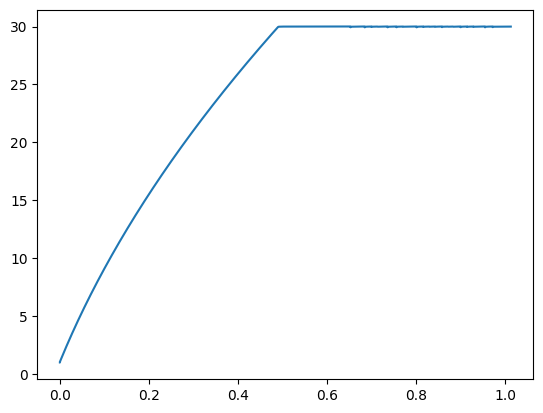

In [ ]:
plt.plot(t_array, np.array(Pcc_array)/1e5)
# plt.plot(t_array, np.array(p_fu_array)/1e5)
# plt.plot(t_array, np.array(p_ox_array) / 1e5)
# plt.xlim([0,0.1])

# print(p_ox_array)

### 3.2 - Turbine

In this section, we test the turbine object to see if it is reasonable.

In [ ]:
turbine = Turbine(I = 1, delta_b=140, a_rat=2, D_m=20e-2, eta=0.4)


Text(0.5, 1.0, 'Analysis of Turbine Performance as a function of Inlet Pressure')

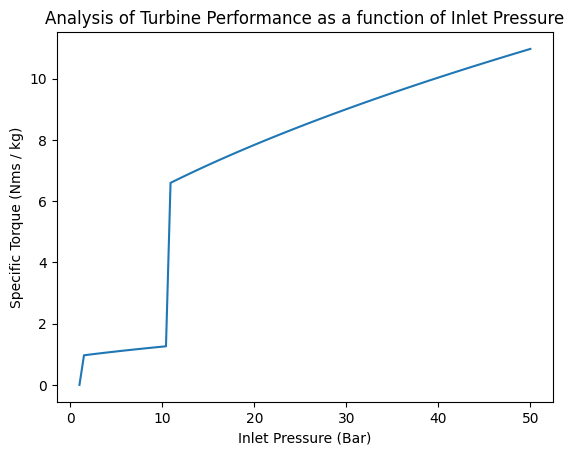

In [ ]:
p_array = np.linspace(1, 50, 100) *1e5

T_o_array = np.linspace(200,1000,100)

T_array = []
P_exit = 1e5

i = 0
for p in p_array:

    T = turbine.get_torque(T_o = T_o_array[i], P_o = p, gamma=1.4, R=400, P_exit=P_exit)

    T_array.append(T)

    i +=1

plt.plot(p_array/1e5,T_array)
plt.xlabel("Inlet Pressure (Bar)")
plt.ylabel("Specific Torque (Nms / kg)")
plt.title("Analysis of Turbine Performance as a function of Inlet Pressure")


We can see the clear transition from subsonic to supersonic flow - implying the solver is working.

In reality, the transition is no where near as jumpy as seen here, but this will do for now.

### 3.3 - Liquid Valve

We will import a simple liquid valve and do a transient analysis on it to see how the expected performance of the system is like.

In [ ]:
valve = LiquidValve(cda = 1, tau=1, s_pos_init=0)

up_str = IncompressibleFluid(rho = 100, P=100e5)
do_str = IncompressibleFluid(rho = 100, P=10e5)


m_dot_array = []
pos_array = []

dt = 0.1
t_array = np.arange(0, 5, dt)

valve.actuate(position=1)

for t in t_array:

    m_dot = valve.get_mdot(upstr=up_str, downstr=do_str, dt=0.1)

    pos = valve.get_pos()
    
    pos_array.append(pos)
    m_dot_array.append(m_dot)

    valve.update_pos(dt=dt)

plt.plot(t_array, m_dot_array)
plt.xlabel("Time (s)")
plt.ylabel("Valve Positon (N/D)")

ZeroDivisionError: float division by zero

Text(0, 0.5, 'Valve Mass Flow Rate (kg/s)')

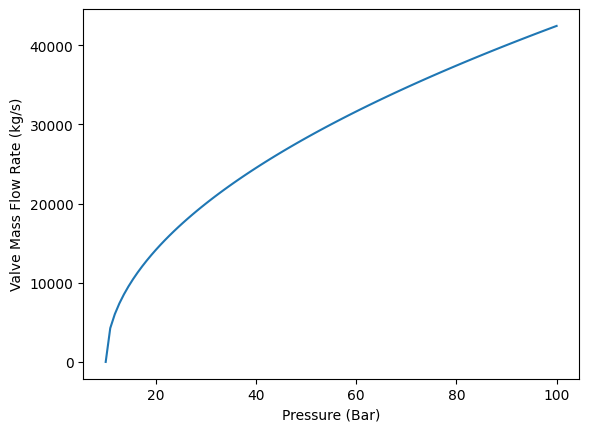

In [3]:
valve = LiquidValve(cda=1, tau=1, s_pos_init=1)

up_str = IncompressibleFluid(rho=100, P=100e5)
do_str = IncompressibleFluid(rho=100, P=10e5)


m_dot_array = []
m_dot_array_2 = []

dt = 0.1

p_array = np.linspace(10,100,100)*1e5


for p in p_array:

    up_str.set_pressure(p)

    m_dot = valve.get_mdot(upstr=up_str, downstr=do_str, dt=0.1)


    m_dot_array.append(m_dot)


plt.plot(p_array / 1e5, m_dot_array)
plt.xlabel("Pressure (Bar)")
plt.ylabel("Valve Mass Flow Rate (kg/s)")

The first order response is demonstrated as expected.

### 3.4 - Pump

For the pump, multiple key parameters are at influence, namely the pump efficiency, the pump head vs flow rate, along with the pump torque.

We will generate plots for these accordingly.

In [1]:
import handcalcs.render
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import matplotlib.pyplot as plt
from turborocket.transient.start_up import (
    GasGenerator,
    Pump,
    Turbine,
    LiquidValve,
    Cavity,
)
from turborocket.fluids.fluids import IncompressibleFluid

Text(0.5, 0, 'Mass Flow (n.d)')

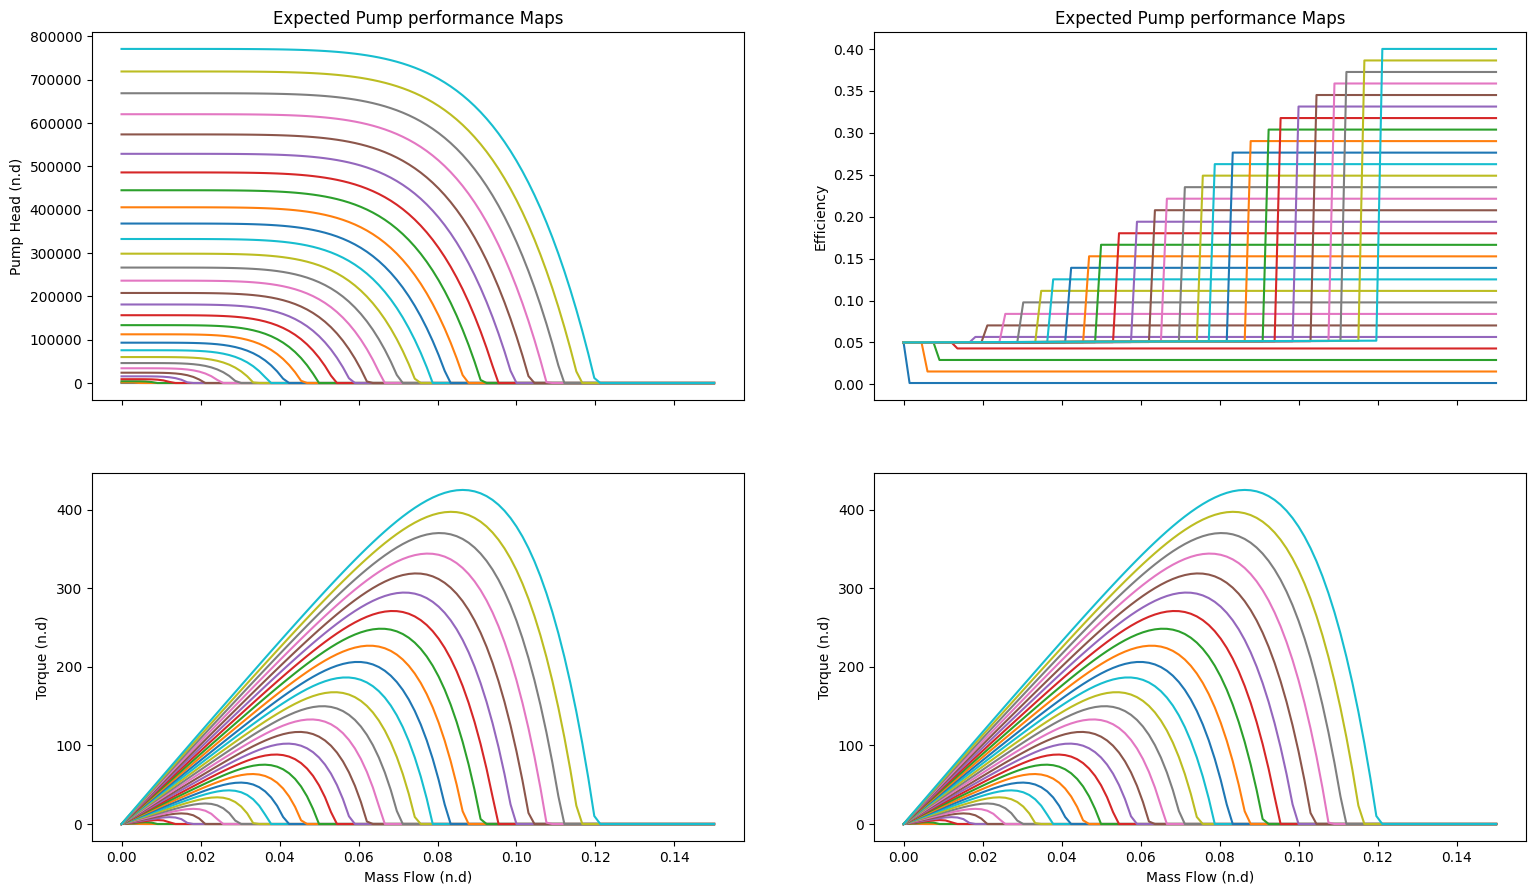

In [2]:
pump = Pump(I=1, D=3e-2, Q_nom=0.08, eta_nom=0.4, N_nom=25e3 * (2 * np.pi) / 60)

inlet = IncompressibleFluid(rho=1000, P=30e5)
k1 = 30
k2 = 100

N = np.linspace(100, 25e3, k1)*(2*np.pi)/60


m_dot = np.linspace(0, 150, k2)

N, m_dot = np.meshgrid(N, m_dot)


dp = np.zeros([k2, k1])
torque = np.zeros([k2, k1])
eta = np.zeros([k2, k1])


i = 0
for Ne in N:

    j = 0
    for m in m_dot[i,:]:
        m = m_dot[i,j]
        ne = N[i, j]

        dp[i, j] = (
            pump.get_exit_condition(inlet=inlet, N=ne, m_dot=m).get_pressure()
            - inlet.get_pressure()
        )

        torque[i, j] = pump.get_torque(inlet=inlet, N=ne, m_dot=m)

        eta[i, j] = pump.get_eta(Q=m / 1000, N = ne)

        j +=1

    i +=1

fig, ax = plt.subplots(2,2, sharex=True)
fig.set_size_inches(18.5, 10.5)
ax[0][0].plot(m_dot / 1000, dp)
ax[0][0].set_ylabel("Pump Head (n.d)")
ax[0][0].set_title("Expected Pump performance Maps")



ax[1][0].plot(m_dot / 1000, torque)
ax[1][0].set_ylabel("Torque (n.d)")
ax[1][0].set_xlabel("Mass Flow (n.d)")


ax[0][1].plot(m_dot / 1000, eta)
ax[0][1].set_ylabel("Efficiency")
ax[0][1].set_title("Expected Pump performance Maps")


ax[1][1].plot(m_dot / 1000, torque)
ax[1][1].set_ylabel("Torque (n.d)")
ax[1][1].set_xlabel("Mass Flow (n.d)")
# plt.plot(m_dot, dp)

In [3]:
pump.get_eta_bep(N=25e3 * (2 * np.pi) / 60)

0.4

<a list of 7 text.Text objects>

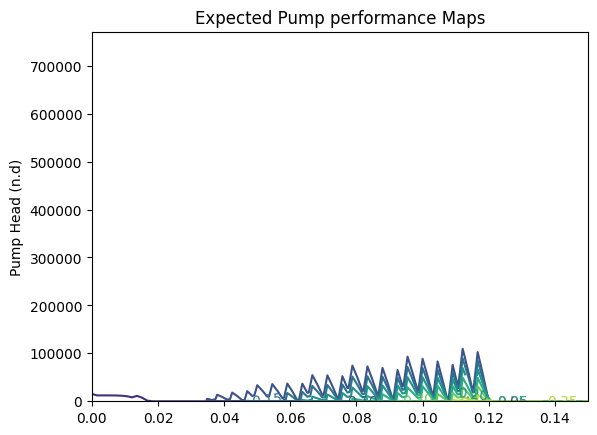

In [3]:
fig.set_size_inches(18.5, 10.5)
# plt.plot(m_dot / 1000, dp)
plt.ylabel("Pump Head (n.d)")
plt.title("Expected Pump performance Maps")
k = plt.contour(m_dot / 1000, dp, eta)
plt.clabel(k, k.levels)

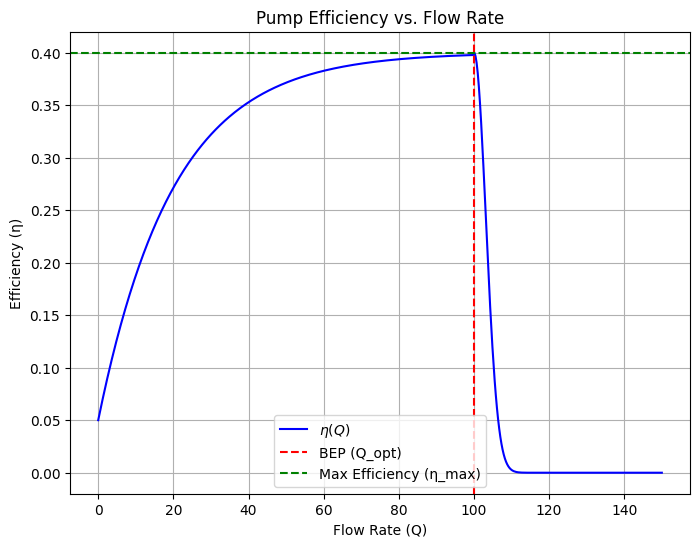

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the pump efficiency model
eta_min = 0.05  # Minimum efficiency at low flow rates
eta_max = 0.40  # Maximum efficiency at BEP
Q_min = 0  # Starting flow rate
Q_opt = 100  # Best Efficiency Point (BEP) flow rate
b = 0.05  # Shape parameter for the slow rise

# Define the flow rate range
Q = np.linspace(Q_min, 150, 500)

# Efficiency model with slow rise and rapid drop-off
eta = eta_min + (eta_max - eta_min) * (1 - np.exp(-b * (Q - Q_min)))
eta[Q > Q_opt] = eta_max * np.exp(
    -0.05 * (Q[Q > Q_opt] - Q_opt) ** 2
)  # Rapid drop-off past BEP

# Plotting the efficiency curve
plt.figure(figsize=(8, 6))
plt.plot(Q, eta, label=r"$\eta(Q)$", color="b")
plt.axvline(x=Q_opt, color="r", linestyle="--", label="BEP (Q_opt)")
plt.axhline(y=eta_max, color="g", linestyle="--", label="Max Efficiency (η_max)")
plt.xlabel("Flow Rate (Q)")
plt.ylabel("Efficiency (η)")
plt.title("Pump Efficiency vs. Flow Rate")
plt.legend()
plt.grid(True)
plt.show()

### 3.5 - Cavity

Finally, the last component we must validate is the cavity.

In [ ]:
cavity_fluid = IncompressibleFluid(rho=1000, P=1e5, B=360e6)

# We can make our volume equivalent to a 3L
V = 3e-3

cavity = Cavity(fluid = cavity_fluid, V = V)

cavity.update_pressure(m_dot=1e-3)

dp = cavity.get_fluid().get_pressure() - 1e5

print(f"Pressure Rise: {dp/1e5} Bar")

Pressure Rise: 1.2 Bar


And that is us - now we can try combining these components to see how the system responds

## 4 - System Validation

This section contains the validation done on combined systems where multiple components are being utilised.

### 4.1 - Engine with Two Main Valves.

This test case is quite simple, consisting of a main engine, with two main simple slow acting valves controlling the addition of propellant into the chamber.

We will initially define our high level fluid conditions:

**Ox**

In [71]:
%%render params sci_not

p_init = 1e5 # Pa
rho_ox = 787 # kg/m**3
B_ox = 1500e6 # Pa

<IPython.core.display.Latex object>

**Fu**

In [72]:
%%render params sci_not

p_init = 1e5 # Pa
rho_fu = 785 # kg/m**3
B_fu = 900e6 # Pa

<IPython.core.display.Latex object>

We can now instantiate our valves.

In [73]:
# We will assume a 1/4" ball valve with a 4.8 mm orifice, using a C_d of 0.8
cda_valve = 0.8*np.pi*((2e-3)/2)**2

ox_valve = LiquidValve(cda = cda_valve, tau = 150e-3, s_pos_init = 0)
fu_valve = LiquidValve(cda = cda_valve, tau = 150e-3, s_pos_init = 0)

# We will now instantiate our cavity, we will assume it's approximately half a liter
ox_injector_fluid = IncompressibleFluid(rho = rho_ox, P = p_init, B = B_ox)
fu_injector_fluid = IncompressibleFluid(rho = rho_fu, P = p_init, B = B_fu)

ox_cavity = Cavity(fluid=ox_injector_fluid, V=0.5e-3)
fu_cavity = Cavity(fluid=fu_injector_fluid, V=0.5e-3)

We need to now instantiate and size our engine automatically - based on desired inlet conditions

In [74]:
%%render parmas sci_not

P_cc = 30e5 # Pa
MR = 3
p_ox = 50e5 # Pa
p_fu = 50e5 # Pa
m_dot = 50e-3 # g/s
eta_c = 0.85
L_star = 1.5 # m
P_cc_init = 1e5

<IPython.core.display.Latex object>

In [75]:
oxidiser = IncompressibleFluid(rho=rho_ox, P=p_ox)
fuel = IncompressibleFluid(rho=rho_fu, P=p_fu)

GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=P_cc, MR=MR)

We can now start the sizing of the system.

In [76]:
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)
_ =GG.size_system(m_dot=m_dot, eta_c=eta_c)
_ = GG.get_geometry()

GG.set_l_star(L_star=L_star)
GG.set_pcc_transient(P_cc_transient=P_cc_init)

ox_valve._pos = 0
fu_valve._pos = 0

ox_cavity._fluid.set_pressure(P=p_init)
fu_cavity._fluid.set_pressure(P=p_init)

We can now setup for our transient analysis!

In [77]:
ox_valve._pos = 0
fu_valve._pos = 0

T_stop = 0.5
T_init = 0

dp = 0.05e5
dt_fix = 0.01
dt_init = 1e-6

# Upstream Fluid Conditions
ox_ups = IncompressibleFluid(P = 50e5, rho = rho_ox)
fu_ups = IncompressibleFluid(P = 50e5, rho = rho_fu)

# We setup our logging array
t_array = [T_init]
Pcc_array = [P_cc_init]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]

ox_valve_array = [0]
fu_valve_array = [0]

p_ox_array = [ox_cavity.get_fluid().get_pressure()]
p_fu_array = [fu_cavity.get_fluid().get_pressure()]

# Initialising
dt = dt_init

ox_valve.actuate(position=1)
fu_valve.actuate(position=1)

while t_array[-1] < T_stop:

    # Firstly we need to update the valve positions
    ox_valve.update_pos(dt = dt)
    fu_valve.update_pos(dt = dt)

    # Now we need to evaluate for the mass-flow through the valves
    m_dot_ox = ox_valve.get_mdot(upstr=ox_ups, downstr=ox_cavity.get_fluid(), dt=dt)
    m_dot_fu = fu_valve.get_mdot(upstr=fu_ups, downstr=fu_cavity.get_fluid(), dt=dt)

    # We can get our injector fluid objects
    inj_ox = ox_cavity.get_fluid()
    inj_fu = fu_cavity.get_fluid()

    # We can do the combustion analysis of the chamber to see how our pressure rise is
    dic = GG.transient_time_step(ox_in = inj_ox, fu_in = inj_fu, eta_c=0.85)

    # We need to now withrdraw from the injector cavitieis

    # We update our cavity
    m_ox_cav = (m_dot_ox - dic["m_dot_o"])*dt
    m_fu_cav = (m_dot_fu - dic["m_dot_f"])*dt

    ox_cavity.update_pressure(m_dot=m_ox_cav)
    fu_cavity.update_pressure(m_dot=m_fu_cav)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])

    m_ox_array.append(dic["m_dot_o"])
    m_fu_array.append(dic["m_dot_f"])

    p_ox_array.append(inj_ox.get_pressure())
    p_fu_array.append(inj_fu.get_pressure())

    ox_valve_array.append(m_dot_ox)
    fu_valve_array.append(m_dot_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step

    dp_dt_ox = (p_ox_array[-2] - p_ox_array[-1]) / dt

    dp_dt_fu = (p_fu_array[-2] - p_fu_array[-1]) / dt

    dp_dt_time = max(abs(dp_dt), abs(dp_dt_ox), abs(dp_dt_fu))

    if dp_dt_time == 0:
        dt = dt_fix
    else:
        dt = dp / dp_dt_time

    if (abs(dt) > dt_fix):
        dt = dt_fix

    t_array.append(t_array[-1] + dt)

    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt * dt)

    print(f"Current Timestep = {t_array[-1]}")

print(Pcc_array)

Current Timestep = 0.01
Current Timestep = 0.010089124018904647
Current Timestep = 0.010098633389726481
Current Timestep = 0.01010822758513163
Current Timestep = 0.010117900644710114
Current Timestep = 0.010127654694004137
Current Timestep = 0.010137491896029709
Current Timestep = 0.010147414461488983
Current Timestep = 0.01015742465127497
Current Timestep = 0.010167524781860166
Current Timestep = 0.010177717231917023
Current Timestep = 0.010188004448956987
Current Timestep = 0.010198388955416813
Current Timestep = 0.01020887335484863
Current Timestep = 0.010219460338235975
Current Timestep = 0.010230152690703844
Current Timestep = 0.010240953298463733
Current Timestep = 0.010251865156048213
Current Timestep = 0.010262891373984518
Current Timestep = 0.010274035186946246
Current Timestep = 0.010285299962357336
Current Timestep = 0.01029668920963054
Current Timestep = 0.010308206590194694
Current Timestep = 0.010319855927975555
Current Timestep = 0.010331641220977005
Current Timestep = 0

(0.0, 10.0)

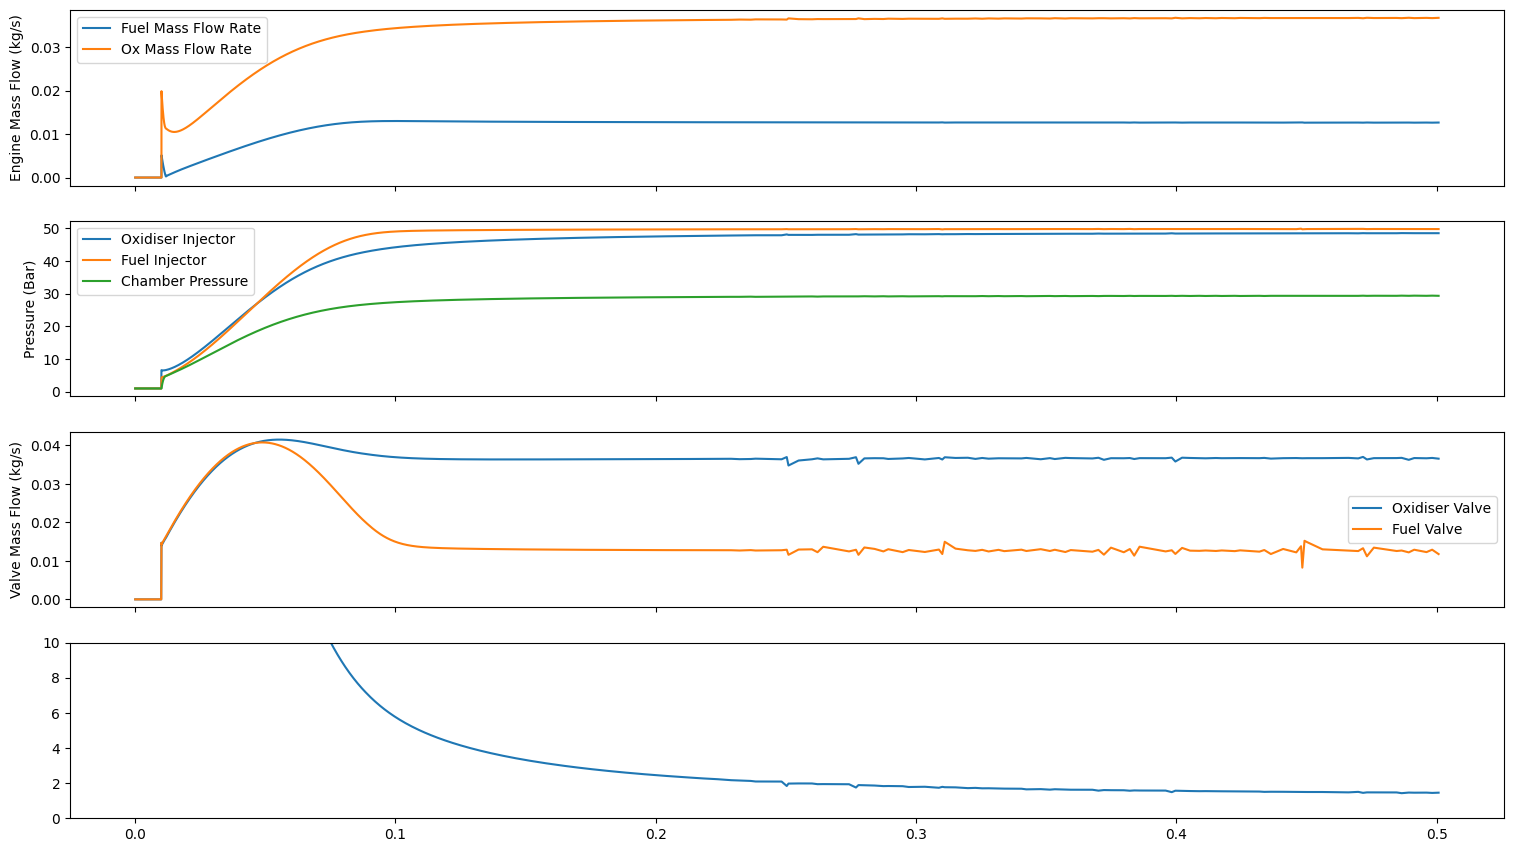

In [78]:
fig, ax = plt.subplots(4, sharex=True)

fig.set_size_inches(18.5, 10.5)

ax[0].plot(t_array, m_fu_array, label="Fuel Mass Flow Rate")
ax[0].plot(t_array, m_ox_array, label="Ox Mass Flow Rate")

ax[0].legend()
ax[0].set_ylabel("Engine Mass Flow (kg/s)")

ax[1].plot(t_array, np.array(p_ox_array) / 1e5, label="Oxidiser Injector")
ax[1].plot(t_array, np.array(p_fu_array) / 1e5, label="Fuel Injector")
ax[1].plot(t_array, np.array(Pcc_array) / 1e5, label="Chamber Pressure")
# plt.plot(t_array, ox_valve_array, label = "Oxidiser Valve")
# plt.plot(t_array, fu_valve_array, label = "Fuel Valve")
ax[1].legend()
ax[1].set_ylabel("Pressure (Bar)")

ax[2].plot(t_array, ox_valve_array, label = "Oxidiser Valve")
ax[2].plot(t_array, fu_valve_array, label = "Fuel Valve")
ax[2].legend()
ax[2].set_ylabel("Valve Mass Flow (kg/s)")

ax[3].plot(t_array, (50e5 - np.array(p_ox_array))/1e5)
ax[3].set_ylim([0,10])
# ax[3].set_xlim([0.01,0.012])

### 4.2 - Pump Spin Up with Fixed Torque and Exit throttle

This test case is a simple case for a pump with fixed torque and a exit thorttle valve used to control the mass-flow throught he valve.

**Valve Instantiation**

In [112]:
# We will assume a 1/4" ball valve with a 4.8 mm orifice, using a C_d of 0.8
cda_throttle = 0.8 * np.pi * ((2e-3) / 2) ** 2

throttle_valve = LiquidValve(cda=cda_throttle, tau=150e-3, s_pos_init=1)


**Pump and Inlet instantiation**

Here, we can assume a nominal inlet pressure of **30 Bar**

In [113]:
pump = Pump(I=1, D=2e-2, Q_nom=0.01, eta_nom=0.4, N_nom=20e3 * (2 * np.pi) / 60)

**Performing Simulation**

In [ ]:
t_stop = 300
t_init = 0

inlet = IncompressibleFluid(rho=1000, P=30e5)

down = IncompressibleFluid(rho=1000, P=10e5)

dt = 0.1

t_array = np.arange(t_init, t_stop, dt)

# We initialise our working variables
N = 0
I = 0.001
m_dot = 0
T_power = 1

# Array
m_throttle_array = []
N_pump_array = []
p_pump_array = []
eta_pump_array = []
T_pump_array = []
dp_max_array = []
q_max_array = []


for t in t_array:

    # We get the exit condition of the pump along with the torque
    pump_exit = pump.get_exit_condition(inlet=inlet, N=N, m_dot=m_dot)
    pump_t = pump.get_torque(inlet=inlet, N=N, m_dot=m_dot)

    # We pass this exit condition to the valve
    m_dot = throttle_valve.get_mdot(upstr=pump_exit, downstr=down, dt=dt)

    # We finally log our key parameters
    m_throttle_array.append(m_dot)

    N_pump_array.append(N)
    p_pump_array.append(pump_exit.get_pressure())
    eta_pump_array.append(pump.get_eta(Q= m_dot / inlet.get_density(), N = N))
    T_pump_array.append(pump_t)
    dp_max_array.append(pump.shut_off_head(N=N))
    q_max_array.append(pump.get_q_max(N=N))

    # We then perform our acceleration based on the delivered torque, and suplied torque
    dn_dt = (T_power - pump_t) / I

    N += dn_dt * dt

Text(0.5, 0, 'Time (s)')

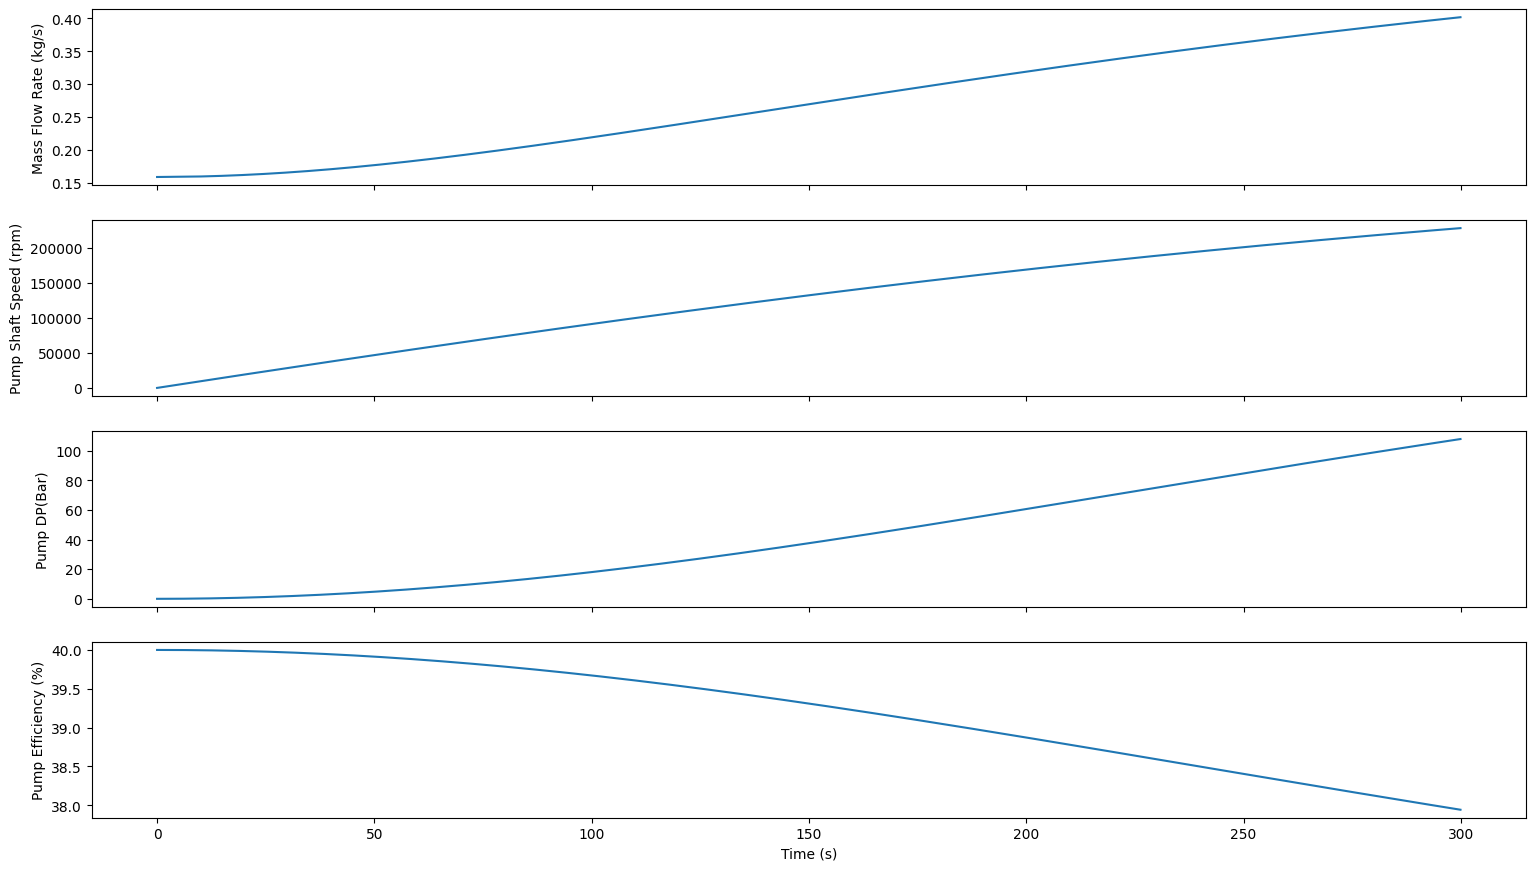

In [115]:
fig, ax = plt.subplots(4, sharex=True)

fig.set_size_inches(18.5, 10.5)

ax[0].plot(t_array, np.array(m_throttle_array), label="Fuel Mass Flow Rate")
ax[0].set_ylabel("Mass Flow Rate (kg/s)")

ax[1].plot(t_array, np.array(N_pump_array)*60/(2 * np.pi), label="Oxidiser Injector")
ax[1].set_ylabel("Pump Shaft Speed (rpm)")

ax[2].plot(t_array, (np.array(p_pump_array) -inlet.get_pressure())/1e5, label="Oxidiser Valve")
ax[2].set_ylabel("Pump DP(Bar)")

ax[3].plot(t_array, np.array(eta_pump_array)*100, label = "Pump Efficiency")
ax[3].set_ylabel("Pump Efficiency (%)")
ax[3].set_xlabel("Time (s)")

[0.00015895 0.00015894 0.00015895 ... 0.00040166 0.00040173 0.0004018 ]


C:\Users\elias\AppData\Local\Temp\ipykernel_27968\3699518093.py:8: RuntimeWarning: divide by zero encountered in divide
  (np.array(m_throttle_array) / inlet.get_density())/np.array(q_max_array),


Text(0, 0.5, 'Pump Efficiency (%)')

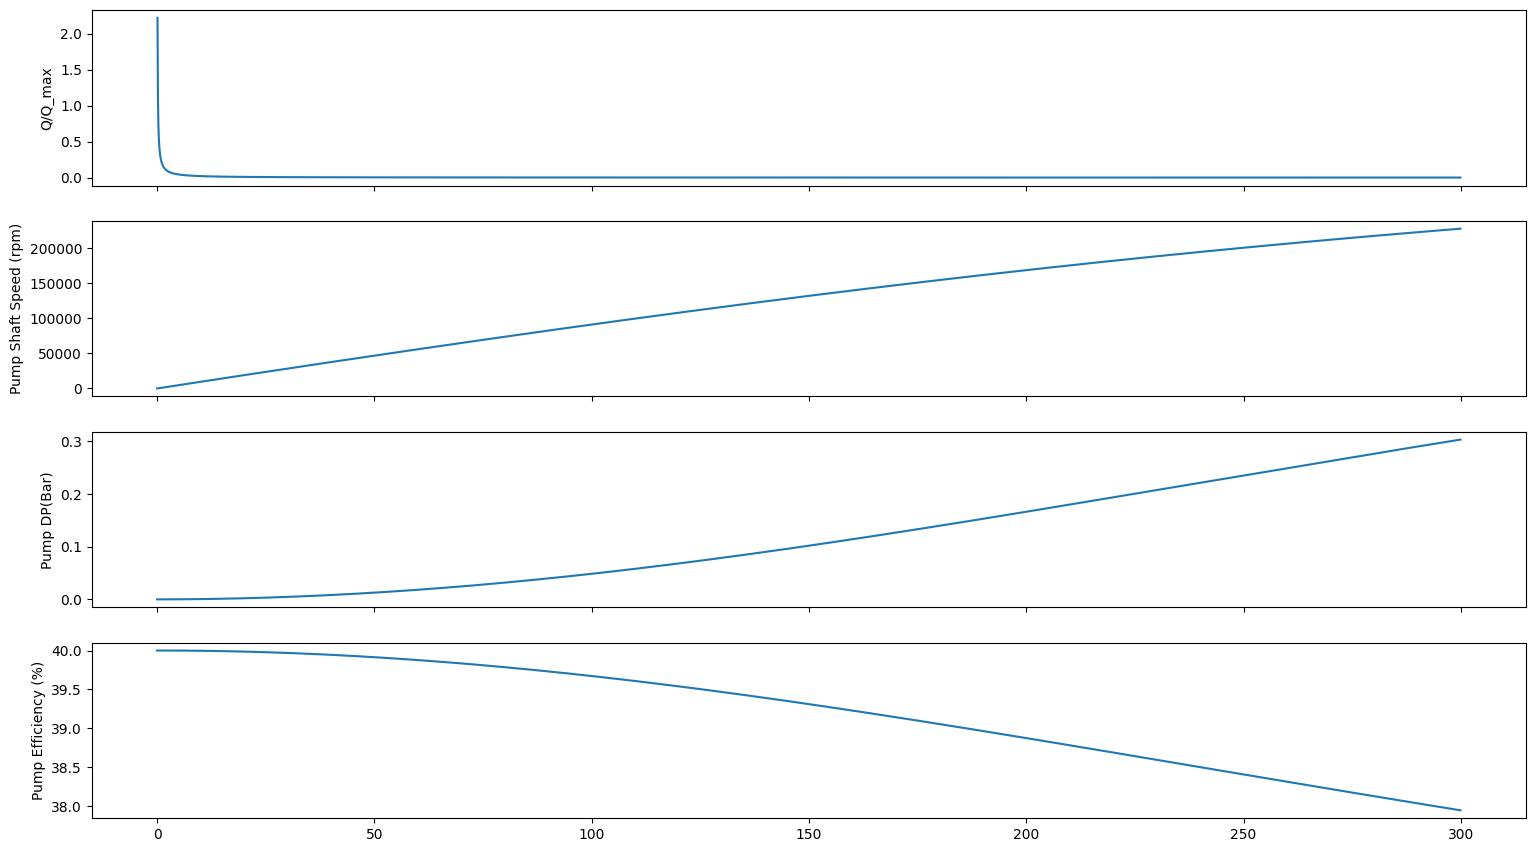

In [29]:
fig, ax = plt.subplots(4, sharex=True)

fig.set_size_inches(18.5, 10.5)
print(np.array(m_throttle_array) / inlet.get_density())

ax[0].plot(
    t_array,
    (np.array(m_throttle_array) / inlet.get_density())/np.array(q_max_array),
    label="Fuel Mass Flow Rate",
)
ax[0].set_ylabel("Q/Q_max")

ax[1].plot(
    t_array, np.array(N_pump_array) * 60 / (2 * np.pi), label="Oxidiser Injector"
)
ax[1].set_ylabel("Pump Shaft Speed (rpm)")

ax[2].plot(
    t_array,
    np.array(dp_max_array)*9.81/1e5,
    label="Oxidiser Valve",
)
ax[2].set_ylabel("Pump DP(Bar)")

ax[3].plot(t_array, np.array(eta_pump_array) * 100, label="Pump Efficiency")
ax[3].set_ylabel("Pump Efficiency (%)")

### 4.3 - Turbopump Spin up with fixed Turbine Inlet Conditions

This test-case aims to demonstrate the coupling between the turbine and the pump to show that a spin-up is possible. No combustion is modelled here, with only fixed inlet conditions assumed for the turbine. A fixed inlet condition to the pump is assumed, along with a valve which remains open, along with a fixed exit condition for the valve.

**Valve Instantiation**

In [33]:
# We will assume a 1/4" ball valve with a 4.8 mm orifice, using a C_d of 0.8
cda_throttle = 0.8 * np.pi * ((2e-3) / 2) ** 2

throttle_valve = LiquidValve(cda=cda_throttle, tau=150e-3, s_pos_init=1)

**Pump Instantiation**

In [34]:
pump = Pump(I=1, D=2e-2, Q_nom=0.01, eta_nom=0.4, N_nom=20e3 * (2 * np.pi) / 60)

**Turbine Instantiation**

In [35]:
turbine = Turbine(I=1, delta_b=140, a_rat=2, D_m=20e-2, eta=0.4)

**Performing Simulation**

In [39]:
t_stop = 300
t_init = 0

# Pump inlet condition and valve exit condition
inlet = IncompressibleFluid(rho=1000, P=30e5)
down = IncompressibleFluid(rho=1000, P=10e5)

# Time array (s)
dt = 0.1
t_array = np.arange(t_init, t_stop, dt)

# We initialise our working variables
N = 0
I = 0.01
m_dot = 0
T_turbine = 0
T_pump = 0

# Array
m_throttle_array = []
N_pump_array = []
p_pump_array = []
eta_pump_array = []
T_pump_array = []
dp_max_array = []
q_max_array = []
T_turbine_array = []

# Turbine Inlet Conditions
T_turb_inlet = 1000
P_turb_inlet = 10e5
gamma_turb_inlet = 1.4
R_turb_inlet = 400
P_turb_exit = 1e5

m_dot_t = 100e-3

for t in t_array:

    # We get the exit condition of the pump along with the torque
    pump_exit = pump.get_exit_condition(inlet=inlet, N=N, m_dot=m_dot)
    pump_t = pump.get_torque(inlet=inlet, N=N, m_dot=m_dot)

    # We pass this exit condition to the valve
    m_dot = throttle_valve.get_mdot(upstr=pump_exit, downstr=down, dt=dt)

    # We evaluate turbine conditions
    turbine_t = m_dot_t * turbine.get_torque(T_o=T_turb_inlet, P_o=P_turb_inlet, gamma=gamma_turb_inlet, R=R_turb_inlet, P_exit=P_turb_exit)

    # We finally log our key parameters
    m_throttle_array.append(m_dot)

    N_pump_array.append(N)
    p_pump_array.append(pump_exit.get_pressure())
    eta_pump_array.append(pump.get_eta(Q=m_dot / inlet.get_density(), N=N))
    T_pump_array.append(pump_t)
    dp_max_array.append(pump.shut_off_head(N=N))
    q_max_array.append(pump.get_q_max(N=N))
    T_turbine_array.append(turbine_t)

    # We then perform our acceleration based on the delivered torque, and suplied torque
    dn_dt = (turbine_t - pump_t) / I

    N += dn_dt * dt

Text(0.5, 0, 'Time (s)')

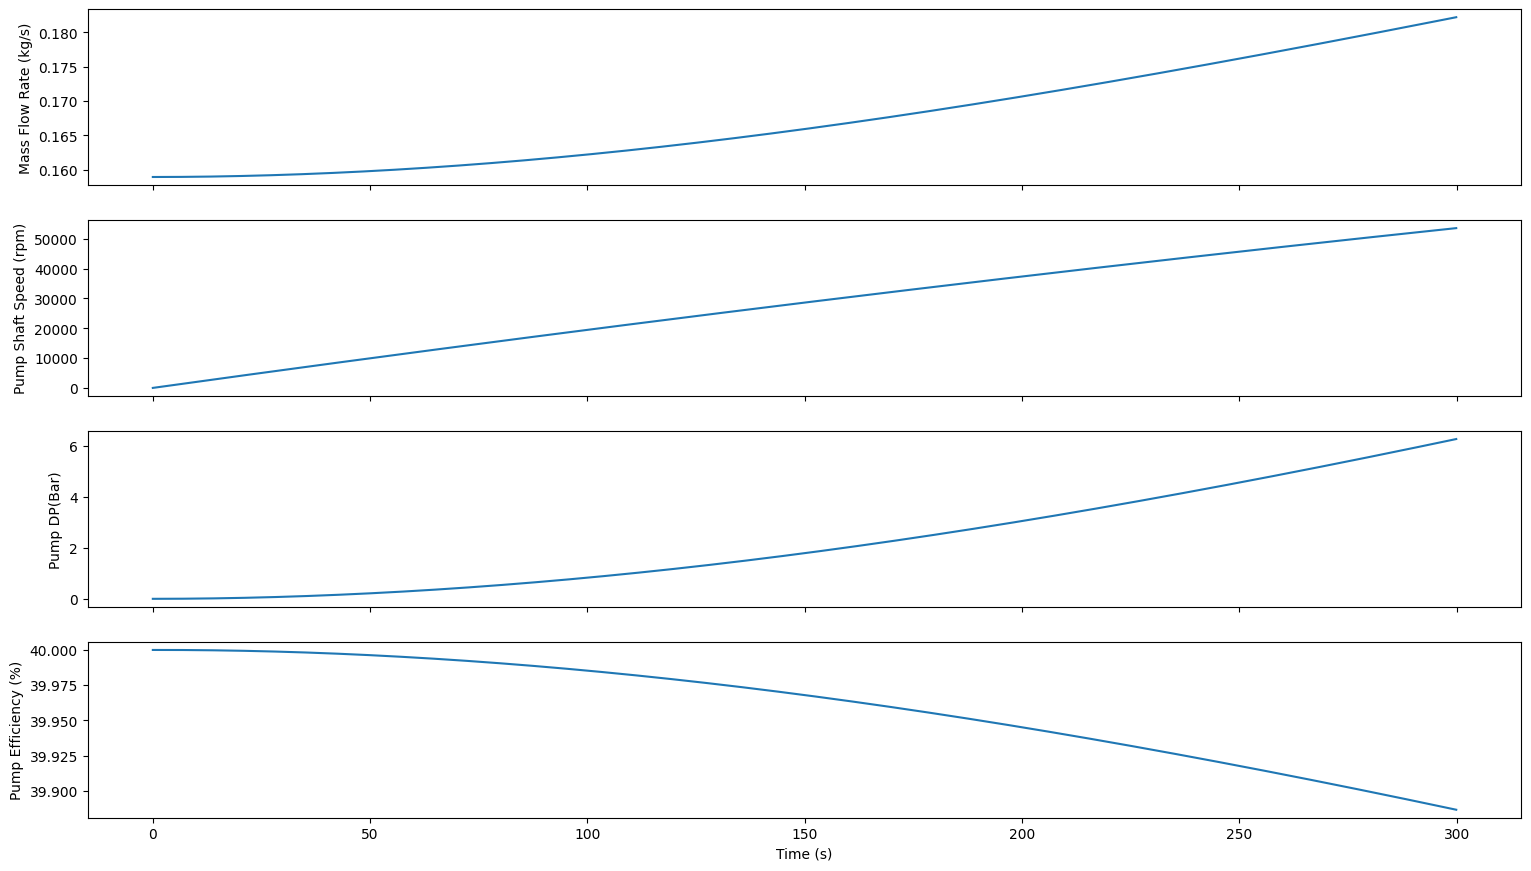

In [40]:
fig, ax = plt.subplots(4, sharex=True)

fig.set_size_inches(18.5, 10.5)

ax[0].plot(t_array, np.array(m_throttle_array), label="Fuel Mass Flow Rate")
ax[0].set_ylabel("Mass Flow Rate (kg/s)")

ax[1].plot(t_array, np.array(N_pump_array)*60/(2 * np.pi), label="Oxidiser Injector")
ax[1].set_ylabel("Pump Shaft Speed (rpm)")

ax[2].plot(t_array, (np.array(p_pump_array) -inlet.get_pressure())/1e5, label="Oxidiser Valve")
ax[2].set_ylabel("Pump DP(Bar)")

ax[3].plot(t_array, np.array(eta_pump_array)*100, label = "Pump Efficiency")
ax[3].set_ylabel("Pump Efficiency (%)")
ax[3].set_xlabel("Time (s)")

[0.00015895 0.00015895 0.00015895 ... 0.00018219 0.0001822  0.00018221]


C:\Users\elias\AppData\Local\Temp\ipykernel_27968\3699518093.py:8: RuntimeWarning: divide by zero encountered in divide
  (np.array(m_throttle_array) / inlet.get_density())/np.array(q_max_array),


Text(0, 0.5, 'Pump Efficiency (%)')

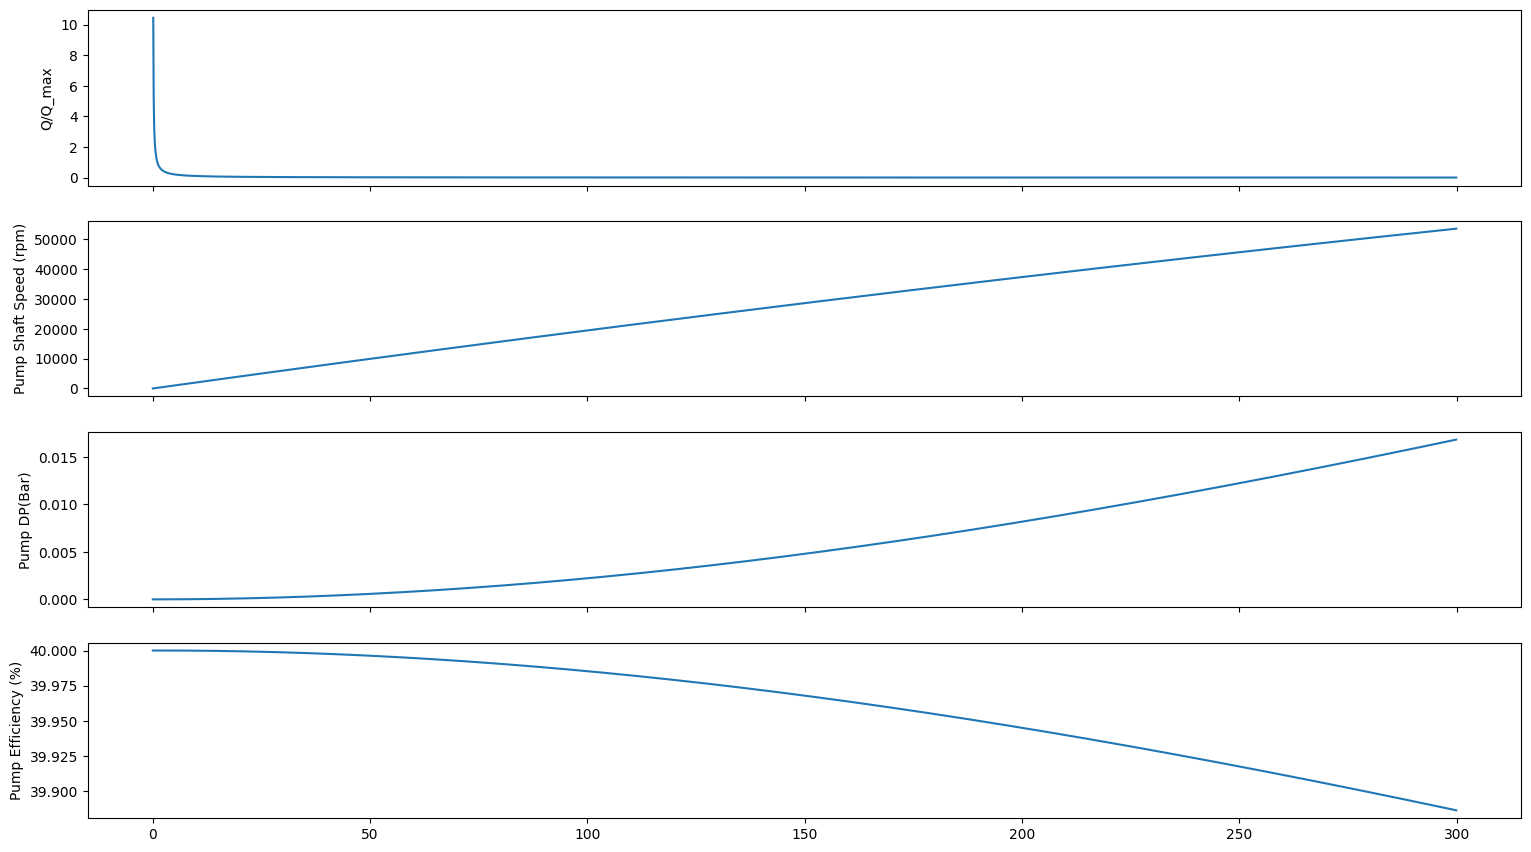

In [42]:
fig, ax = plt.subplots(4, sharex=True)

fig.set_size_inches(18.5, 10.5)
print(np.array(m_throttle_array) / inlet.get_density())

ax[0].plot(
    t_array,
    (np.array(m_throttle_array) / inlet.get_density())/np.array(q_max_array),
    label="Fuel Mass Flow Rate",
)
ax[0].set_ylabel("Q/Q_max")

ax[1].plot(
    t_array, np.array(N_pump_array) * 60 / (2 * np.pi), label="Oxidiser Injector"
)
ax[1].set_ylabel("Pump Shaft Speed (rpm)")

ax[2].plot(
    t_array,
    np.array(dp_max_array)*9.81/1e5,
    label="Oxidiser Valve",
)
ax[2].set_ylabel("Pump DP(Bar)")

ax[3].plot(t_array, np.array(eta_pump_array) * 100, label="Pump Efficiency")
ax[3].set_ylabel("Pump Efficiency (%)")

### 4.4 - Turbo-pump with Gas Generator Indepedently Driven

This case is a combination of `test case 4.1` and `test case 4.3` where we simualte the start up of the turbopump.

**Ox**

In [148]:
%%render params sci_not

p_init = 1e5 # Pa
rho_ox = 787 # kg/m**3
B_ox = 1500e6 # Pa

<IPython.core.display.Latex object>

**Fu**

In [149]:
%%render params sci_not

p_init = 1e5 # Pa
rho_fu = 785 # kg/m**3
B_fu = 900e6 # Pa

<IPython.core.display.Latex object>

**Valve Instantiation**

In [150]:
# We will assume a 1/4" ball valve with a 4.8 mm orifice, using a C_d of 0.8
cda_throttle = 0.8 * np.pi * ((2e-3) / 2) ** 2
cda_valve = 0.6 * np.pi * ((2e-3) / 2) ** 2

throttle_valve = LiquidValve(cda=cda_throttle, tau=150e-3, s_pos_init=1)
ox_valve = LiquidValve(cda=cda_valve, tau=150e-3, s_pos_init=0)
fu_valve = LiquidValve(cda=cda_valve, tau=150e-3, s_pos_init=0)

# We will now instantiate our cavity, we will assume it's approximately half a liter
ox_injector_fluid = IncompressibleFluid(rho=rho_ox, P=p_init, B=B_ox)
fu_injector_fluid = IncompressibleFluid(rho=rho_fu, P=p_init, B=B_fu)

ox_cavity = Cavity(fluid=ox_injector_fluid, V=0.5e-3)
fu_cavity = Cavity(fluid=fu_injector_fluid, V=0.5e-3)

**Pump Instantiation**

In [151]:
pump = Pump(I=1, D=2e-2, Q_nom=0.01, eta_nom=0.4, N_nom=20e3 * (2 * np.pi) / 60)

**Turbine Instantiation**

In [152]:
turbine = Turbine(I=1, delta_b=140, a_rat=2, D_m=20e-2, eta=0.4)

**Gas Generator Instantiation and Sizing**

In [153]:
%%render parmas sci_not

P_cc = 30e5 # Pa
MR = 3
p_ox = 50e5 # Pa
p_fu = 50e5 # Pa
m_dot = 50e-3 # g/s
eta_c = 0.85
L_star = 1.5 # m
P_cc_init = 1e5

<IPython.core.display.Latex object>

In [154]:
oxidiser = IncompressibleFluid(rho=rho_ox, P=p_ox)
fuel = IncompressibleFluid(rho=rho_fu, P=p_fu)

GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=P_cc, MR=MR)

We can now start the sizing of the system.

In [155]:
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)
_ =GG.size_system(m_dot=m_dot, eta_c=eta_c)
_ = GG.get_geometry()

GG.set_l_star(L_star=L_star)
GG.set_pcc_transient(P_cc_transient=P_cc_init)

ox_valve._pos = 0
fu_valve._pos = 0
throttle_valve._pos = 0

ox_cavity._fluid.set_pressure(P=p_init)
fu_cavity._fluid.set_pressure(P=p_init)

**Performing the Simulation**

In [156]:
t_stop = 10
t_init = 0

# Pump inlet condition and valve exit condition
inlet = IncompressibleFluid(rho=1000, P=30e5)
down = IncompressibleFluid(rho=1000, P=10e5)

# We initialise our working variables
N = 0
I = 0.001
m_dot = 0
T_turbine = 0
T_pump = 0

# Array
m_throttle_array = [0]
N_pump_array = [N]
p_pump_array = [inlet.get_pressure()]
eta_pump_array = [pump.get_eta(Q=0, N=N)]
T_pump_array = [pump.get_torque(inlet=inlet, N=N, m_dot=0)]
T_turbine_array = [0]

t_array = [t_init]

Pcc_array = [P_cc_init]
dp_dt_array = [0]

T_array = [0]

MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]


# Upstream Fluid Conditions
ox_ups = IncompressibleFluid(P=50e5, rho=rho_ox)
fu_ups = IncompressibleFluid(P=50e5, rho=rho_fu)

# We setup our logging array
t_array = [t_init]
Pcc_array = [P_cc_init]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]

ox_valve_array = [0]
fu_valve_array = [0]

p_ox_array = [ox_cavity.get_fluid().get_pressure()]
p_fu_array = [fu_cavity.get_fluid().get_pressure()]

################### SIMULATION CONDITIONS ###################
dp = 0.05e5
dt_fix = 0.01
dt_init = 1e-6
dt = dt_init

P_exit = 1e5

ox_valve.actuate(position=1)
fu_valve.actuate(position=1)
throttle_valve.actuate(position=1)

while t_array[-1] < t_stop:

    ######################### turbine condition updatig ##############################
    # Firstly we need to update the valve positions
    ox_valve.update_pos(dt=dt)
    fu_valve.update_pos(dt=dt)
    throttle_valve.update_pos(dt=dt)

    # Now we need to evaluate for the mass-flow through the valves
    m_dot_ox = ox_valve.get_mdot(upstr=ox_ups, downstr=ox_cavity.get_fluid(), dt=dt)
    m_dot_fu = fu_valve.get_mdot(upstr=fu_ups, downstr=fu_cavity.get_fluid(), dt=dt)
    m_dot = throttle_valve.get_mdot(upstr=pump_exit, downstr=down, dt=dt)
    
    # We can get our injector fluid objects
    inj_ox = ox_cavity.get_fluid()
    inj_fu = fu_cavity.get_fluid()

    # We can do the combustion analysis of the chamber to see how our pressure rise is
    dic = GG.transient_time_step(ox_in=inj_ox, fu_in=inj_fu, eta_c=0.85)

    # We need to now withrdraw from the injector cavitieis

    # We update our cavity
    m_ox_cav = (m_dot_ox - dic["m_dot_o"]) * dt
    m_fu_cav = (m_dot_fu - dic["m_dot_f"]) * dt

    ox_cavity.update_pressure(m_dot=m_ox_cav)
    fu_cavity.update_pressure(m_dot=m_fu_cav)

    # We get the exit condition of the pump along with the torque
    pump_exit = pump.get_exit_condition(inlet=inlet, N=N, m_dot=m_dot)
    pump_t = pump.get_torque(inlet=inlet, N=N, m_dot=m_dot)

    R_gas = dic["Cp"] * (dic["gamma"] - 1) / dic["gamma"]

    # We evaluate turbine conditions
    turbine_t = dic["m_dot_t"] * turbine.get_torque(
        T_o=dic["T_o"],
        P_o=dic["P_cc"],
        gamma=dic["gamma"],
        R=R_gas,
        P_exit=P_exit,
    )

    # We finally log our key parameters
    m_throttle_array.append(m_dot)

    N_pump_array.append(N)
    p_pump_array.append(pump_exit.get_pressure())
    eta_pump_array.append(pump.get_eta(Q=m_dot / inlet.get_density(), N=N))
    T_pump_array.append(pump_t)
    dp_max_array.append(pump.shut_off_head(N=N))
    q_max_array.append(pump.get_q_max(N=N))
    T_turbine_array.append(turbine_t)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])

    m_ox_array.append(dic["m_dot_o"])
    m_fu_array.append(dic["m_dot_f"])

    p_ox_array.append(inj_ox.get_pressure())
    p_fu_array.append(inj_fu.get_pressure())

    ox_valve_array.append(m_dot_ox)
    fu_valve_array.append(m_dot_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step

    dp_dt_ox = (p_ox_array[-2] - p_ox_array[-1]) / dt

    dp_dt_fu = (p_fu_array[-2] - p_fu_array[-1]) / dt

    dp_dt_time = max(abs(dp_dt), abs(dp_dt_ox), abs(dp_dt_fu))

    if dp_dt_time == 0:
        dt = dt_fix
    else:
        dt = dp / dp_dt_time

    if abs(dt) > dt_fix:
        dt = dt_fix

    t_array.append(t_array[-1] + dt)

    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt * dt)

    print(f"Current Timestep = {t_array[-1]}")

    # We then perform our acceleration based on the delivered torque, and suplied torque
    dn_dt = (turbine_t - pump_t) / I

    N += dn_dt * dt

Current Timestep = 0.01
Current Timestep = 0.010118841194921756
Current Timestep = 0.010129940428564705
Current Timestep = 0.010141182298821824
Current Timestep = 0.01015254718989832
Current Timestep = 0.010164039160145652
Current Timestep = 0.010175662413274906
Current Timestep = 0.01018742131950509
Current Timestep = 0.0101993204304181
Current Timestep = 0.010211364496105347
Current Timestep = 0.010223558484235541
Current Timestep = 0.010235907599627704
Current Timestep = 0.010248417305338592
Current Timestep = 0.010261093345450195
Current Timestep = 0.01027394176982633
Current Timestep = 0.010286968961287505
Current Timestep = 0.010300181665232718
Current Timestep = 0.010313587022532114
Current Timestep = 0.010327192605806921
Current Timestep = 0.010341006459717582
Current Timestep = 0.010355037145947618
Current Timestep = 0.010369293793673478
Current Timestep = 0.010383786155786584
Current Timestep = 0.010398524672828533
Current Timestep = 0.010413520544714564
Current Timestep = 0.

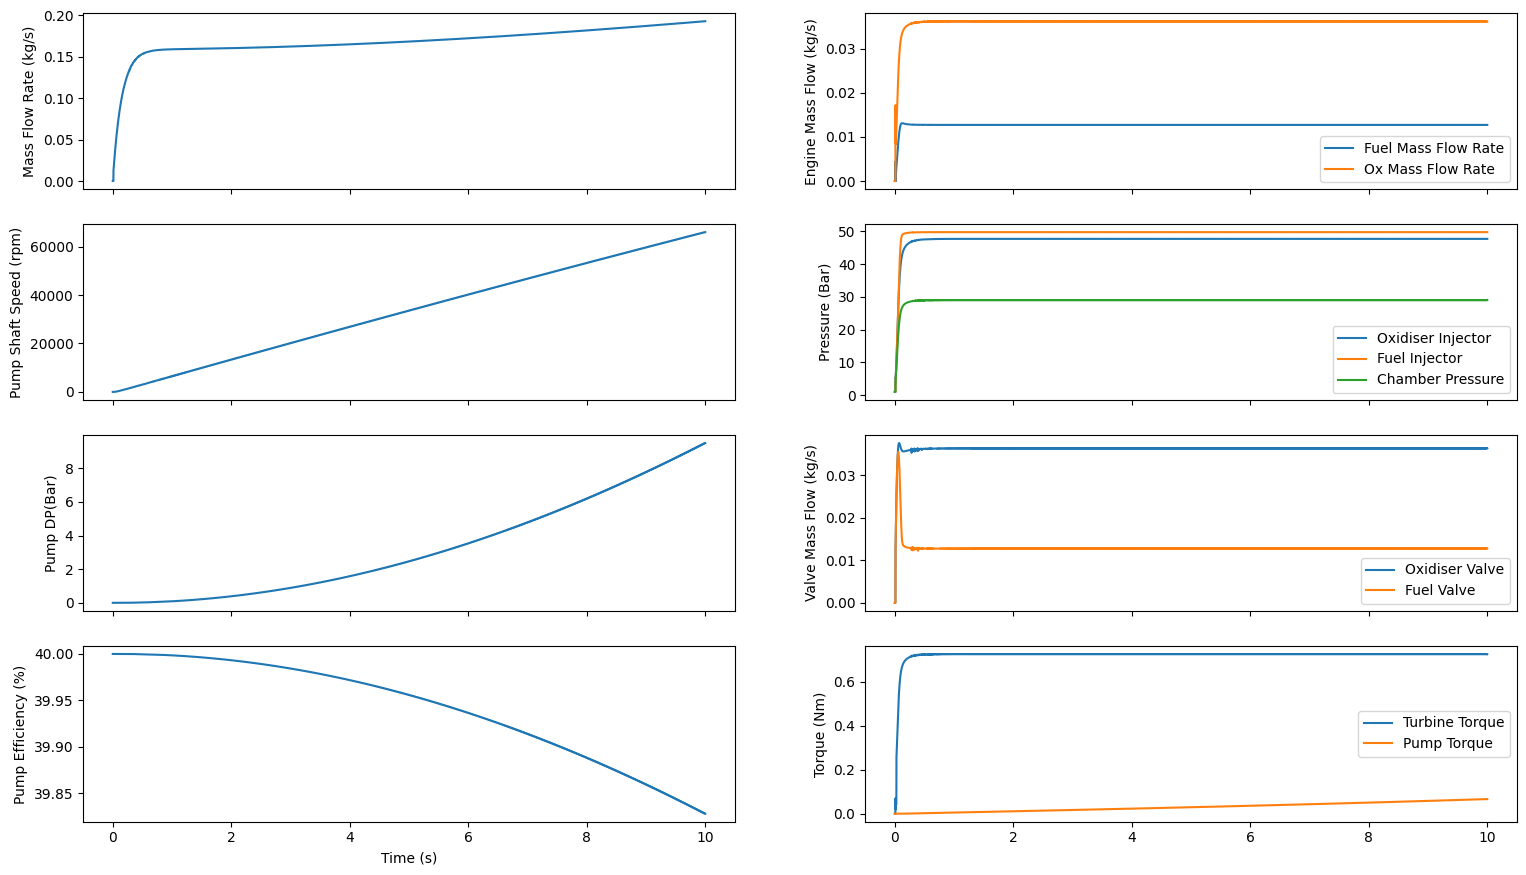

In [158]:
fig, ax = plt.subplots(4,2, sharex=True)

fig.set_size_inches(18.5, 10.5)

ax[0][0].plot(t_array, np.array(m_throttle_array), label="Fuel Mass Flow Rate")
ax[0][0].set_ylabel("Mass Flow Rate (kg/s)")

ax[1][0].plot(
    t_array, np.array(N_pump_array) * 60 / (2 * np.pi), label="Oxidiser Injector"
)
ax[1][0].set_ylabel("Pump Shaft Speed (rpm)")

ax[2][0].plot(
    t_array,
    (np.array(p_pump_array) - inlet.get_pressure()) / 1e5,
    label="Oxidiser Valve",
)
ax[2][0].set_ylabel("Pump DP(Bar)")

ax[3][0].plot(t_array, np.array(eta_pump_array) * 100, label="Pump Efficiency")
ax[3][0].set_ylabel("Pump Efficiency (%)")
ax[3][0].set_xlabel("Time (s)")


ax[0][1].plot(t_array, m_fu_array, label="Fuel Mass Flow Rate")
ax[0][1].plot(t_array, m_ox_array, label="Ox Mass Flow Rate")

ax[0][1].legend()
ax[0][1].set_ylabel("Engine Mass Flow (kg/s)")

ax[1][1].plot(t_array, np.array(p_ox_array) / 1e5, label="Oxidiser Injector")
ax[1][1].plot(t_array, np.array(p_fu_array) / 1e5, label="Fuel Injector")
ax[1][1].plot(t_array, np.array(Pcc_array) / 1e5, label="Chamber Pressure")
# plt.plot(t_array, ox_valve_array, label = "Oxidiser Valve")
# plt.plot(t_array, fu_valve_array, label = "Fuel Valve")
ax[1][1].legend()
ax[1][1].set_ylabel("Pressure (Bar)")

ax[2][1].plot(t_array, ox_valve_array, label="Oxidiser Valve")
ax[2][1].plot(t_array, fu_valve_array, label="Fuel Valve")
ax[2][1].legend()
ax[2][1].set_ylabel("Valve Mass Flow (kg/s)")

ax[3][1].plot(t_array, np.array(T_turbine_array), label="Turbine Torque")
ax[3][1].plot(t_array, np.array(T_pump_array), label="Pump Torque")
ax[3][1].set_ylabel("Torque (Nm)")
ax[3][1].legend()

### 4.5 - Turbo-pump with Gas Generator Fully Coupled

This is an extension case for `test case 4.4`, with this time considering the gas generator being supplied to by the pump exit conditions.

**Ox**

In [99]:
%%render params sci_not

p_init = 1e5 # Pa
rho_ox = 787 # kg/m**3
B_ox = 1500e6 # Pa

<IPython.core.display.Latex object>

**Fu**

In [100]:
%%render params sci_not

p_init = 1e5 # Pa
rho_fu = 785 # kg/m**3
B_fu = 900e6 # Pa

<IPython.core.display.Latex object>

**Valve Instantiation**

In [ ]:
# We will assume a 1/4" ball valve with a 4.8 mm orifice, using a C_d of 0.8
cda_valve = 0.6 * np.pi * ((2e-3) / 2) ** 2

ox_valve = LiquidValve(cda=cda_valve, tau=150e-3, s_pos_init=0)
fu_valve = LiquidValve(cda=cda_valve, tau=150e-3, s_pos_init=0)

# We will now instantiate our cavity, we will assume it's approximately half a liter
ox_injector_fluid = IncompressibleFluid(rho=rho_ox, P=p_init, B=B_ox)
fu_injector_fluid = IncompressibleFluid(rho=rho_fu, P=p_init, B=B_fu)
 
ox_cavity = Cavity(fluid=ox_injector_fluid, V=0.5e-3)
fu_cavity = Cavity(fluid=fu_injector_fluid, V=0.5e-3)

**Pump Instantiation**

In [102]:
pump = Pump(I=1, D=2e-2, Q_nom=0.001, eta_nom=0.4, N_nom=20e3 * (2 * np.pi) / 60)

**Turbine Instantiation**

In [103]:
turbine = Turbine(I=1, delta_b=140, a_rat=2, D_m=20e-2, eta=0.4)

**Gas Generator Instantiation and Sizing**

In [104]:
%%render parmas sci_not

P_cc = 30e5 # Pa
MR = 3
p_ox = 50e5 # Pa
p_fu = 50e5 # Pa
m_dot = 50e-3 # g/s
eta_c = 0.85
L_star = 1.5 # m
P_cc_init = 1e5

<IPython.core.display.Latex object>

In [105]:
oxidiser = IncompressibleFluid(rho=rho_ox, P=p_ox)
fuel = IncompressibleFluid(rho=rho_fu, P=p_fu)

GG = GasGenerator(Ox="N2O", Fu="Isopropanol", Pcc=P_cc, MR=MR)

We can now start the sizing of the system.

In [106]:
GG.injector_cond(ox_in=oxidiser, fu_in=fuel, cdo=0.6, cdf=0.6)
_ =GG.size_system(m_dot=m_dot, eta_c=eta_c)
_ = GG.get_geometry()

GG.set_l_star(L_star=L_star)
GG.set_pcc_transient(P_cc_transient=P_cc_init)

ox_valve._pos = 0
fu_valve._pos = 0


ox_cavity._fluid.set_pressure(P=p_init)
fu_cavity._fluid.set_pressure(P=p_init)

**Performing the Simulation**

In [107]:
t_stop = 10
t_init = 0

alpha = 0.2

# Pump inlet condition and valve exit condition
inlet = IncompressibleFluid(rho=1000, P=30e5)
down = IncompressibleFluid(rho=1000, P=10e5)

# We initialise our working variables
N = 0
I = 0.001
m_dot_fu = 0
T_turbine = 0
T_pump = 0
m_dot_ox = 0


# Array
N_pump_array = [N]
p_pump_array = [inlet.get_pressure()]
eta_pump_array = [pump.get_eta(Q=0, N=N)]
T_pump_array = [pump.get_torque(inlet=inlet, N=N, m_dot=0)]
T_turbine_array = [0]

t_array = [t_init]

Pcc_array = [P_cc_init]
dp_dt_array = [0]

T_array = [0]

MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]


# Upstream Fluid Conditions
ox_ups = IncompressibleFluid(P=50e5, rho=rho_ox)
fu_ups = IncompressibleFluid(P=50e5, rho=rho_fu)

# We setup our logging array
t_array = [t_init]
Pcc_array = [P_cc_init]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]

ox_valve_array = [0]
fu_valve_array = [0]

p_ox_array = [ox_cavity.get_fluid().get_pressure()]
p_fu_array = [fu_cavity.get_fluid().get_pressure()]

################### SIMULATION CONDITIONS ###################
dp = 0.05e5
dt_fix = 0.01
dt_init = 1e-6
dt = dt_init

P_exit = 1e5

ox_valve.actuate(position=1)
fu_valve.actuate(position=1)

while t_array[-1] < t_stop:
    ######################## Get Pump Exit Parameters #######################
    pump_exit = pump.get_exit_condition(inlet=inlet, N=N, m_dot=m_dot_fu)
    pump_t = pump.get_torque(inlet=inlet, N=N, m_dot=m_dot_fu)

    ######################### turbine condition updatig ##############################
    # Firstly we need to update the valve positions
    ox_valve.update_pos(dt=dt)
    fu_valve.update_pos(dt=dt)

    # Now we need to evaluate for the instantaneous mass flow rates
    m_dot_ox = (
        alpha * ox_valve.get_mdot(upstr=ox_ups, downstr=ox_cavity.get_fluid(), dt=dt)
    ) + (1 - alpha) * ox_valve_array[-1]
    
    m_dot_fu = alpha * fu_valve.get_mdot(
        upstr=pump_exit, downstr=fu_cavity.get_fluid(), dt=dt
    ) + (1 - alpha)*fu_valve_array[-1]

    # We can get our injector fluid objects
    inj_ox = ox_cavity.get_fluid()
    inj_fu = fu_cavity.get_fluid()

    # We can do the combustion analysis of the chamber to see how our pressure rise is
    dic = GG.transient_time_step(ox_in=inj_ox, fu_in=inj_fu, eta_c=0.85)

    # We update our cavity using the last mass_flow_rates
    m_ox_cav = (m_dot_ox - dic["m_dot_o"]) * dt
    m_fu_cav = (m_dot_fu - dic["m_dot_f"]) * dt

    ox_cavity.update_pressure(m_dot=m_ox_cav)
    fu_cavity.update_pressure(m_dot=m_fu_cav)

    # We get the exit condition of the pump along with the torque

    R_gas = dic["Cp"] * (dic["gamma"] - 1) / dic["gamma"]

    # We evaluate turbine conditions
    turbine_t = dic["m_dot_t"] * turbine.get_torque(
        T_o=dic["T_o"],
        P_o=dic["P_cc"],
        gamma=dic["gamma"],
        R=R_gas,
        P_exit=P_exit,
    )

    N_pump_array.append(N)
    p_pump_array.append(pump_exit.get_pressure())
    eta_pump_array.append(pump.get_eta(Q=m_dot / inlet.get_density(), N=N))
    T_pump_array.append(pump_t)
    T_turbine_array.append(turbine_t)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])

    m_ox_array.append(dic["m_dot_o"])
    m_fu_array.append(dic["m_dot_f"])

    p_ox_array.append(inj_ox.get_pressure())
    p_fu_array.append(inj_fu.get_pressure())

    ox_valve_array.append(m_dot_ox)
    fu_valve_array.append(m_dot_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step

    dp_dt_ox = (p_ox_array[-2] - p_ox_array[-1]) / dt

    dp_dt_fu = (p_fu_array[-2] - p_fu_array[-1]) / dt

    dp_dt_time = max(abs(dp_dt), abs(dp_dt_ox), abs(dp_dt_fu))

    if dp_dt_time == 0:
        dt = dt_fix
    else:
        dt = dp / dp_dt_time

    if abs(dt) > dt_fix:
        dt = dt_fix

    t_array.append(t_array[-1] + dt)

    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt * dt)

    print(f"Current Timestep = {t_array[-1]}")

    # We then perform our acceleration based on the delivered torque, and suplied torque
    dn_dt = (turbine_t - pump_t) / I

    N += dn_dt * dt

Current Timestep = 0.01
Current Timestep = 0.01059437329337285
Current Timestep = 0.010622441529487244
Current Timestep = 0.010653439566101514
Current Timestep = 0.010686486082456786
Current Timestep = 0.010721937383220942
Current Timestep = 0.010760273781393213
Current Timestep = 0.010802170471833178
Current Timestep = 0.010848627333880973
Current Timestep = 0.010901232415193661
Current Timestep = 0.010962781412992298
Current Timestep = 0.011039180276256898
Current Timestep = 0.011150709395563048
Current Timestep = 0.011248693696899466
Current Timestep = 0.011324386948157994
Current Timestep = 0.011421414156675448
Current Timestep = 0.01151460247590342
Current Timestep = 0.011586638515332023
Current Timestep = 0.011675855953099263
Current Timestep = 0.011836251722632312
Current Timestep = 0.011929407089193036
Current Timestep = 0.012003816433985175
Current Timestep = 0.01209639237737086
Current Timestep = 0.012265685601298126
Current Timestep = 0.012354338686234487
Current Timestep = 

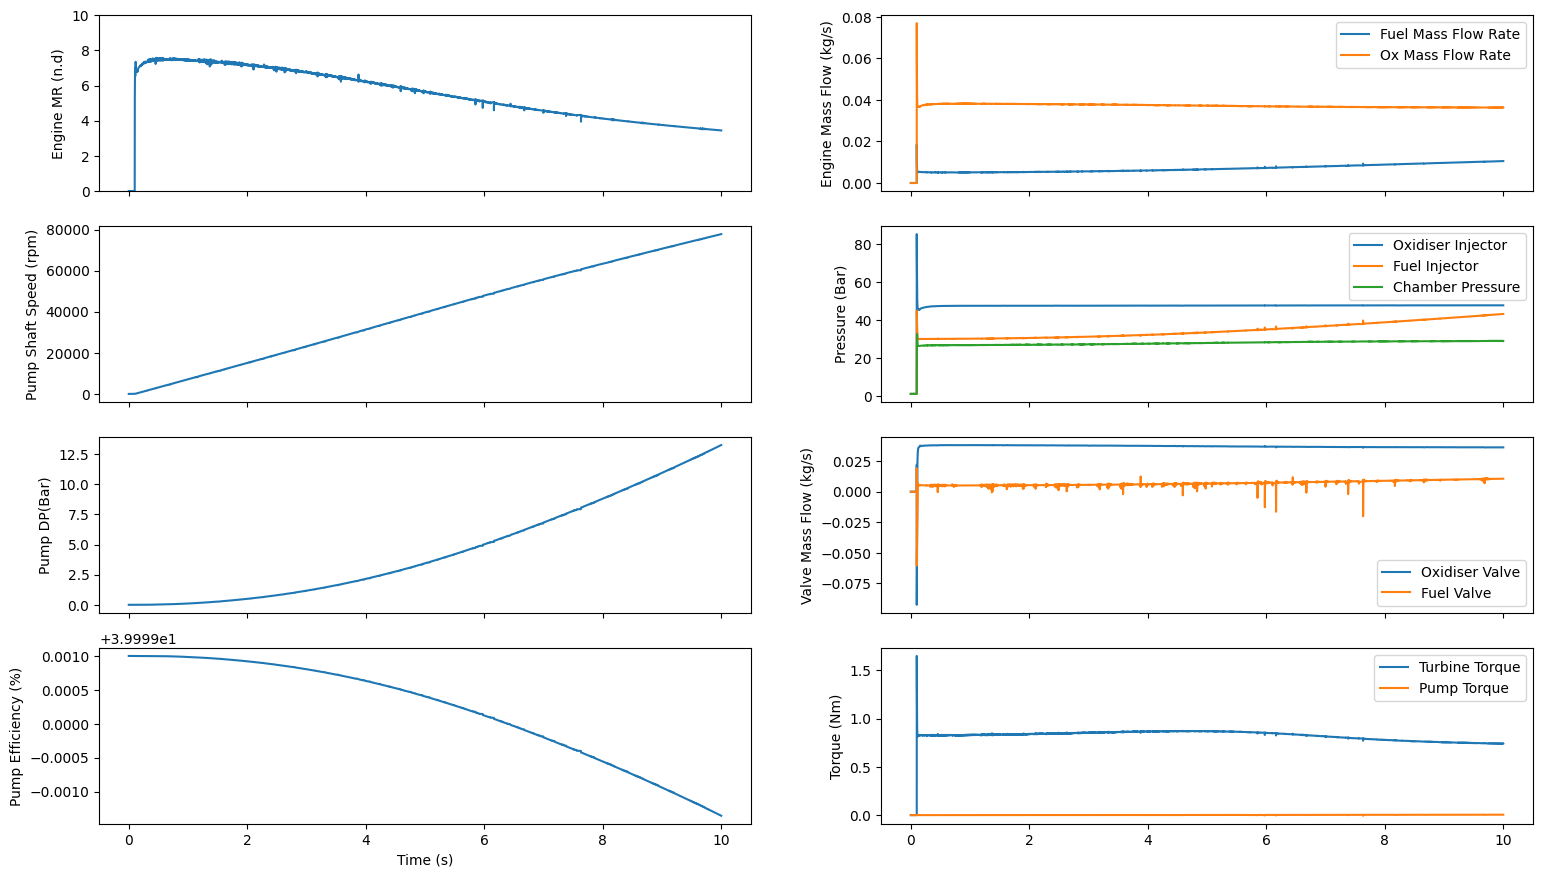

In [98]:
fig, ax = plt.subplots(4,2, sharex=True)

fig.set_size_inches(18.5, 10.5)

ax[0][0].plot(t_array, np.array(MR_array), label="Fuel Mass Flow Rate")
ax[0][0].set_ylabel("Engine MR (n.d)")
ax[0][0].set_ylim([0,10])

ax[1][0].plot(
    t_array, np.array(N_pump_array) * 60 / (2 * np.pi), label="Oxidiser Injector"
)
ax[1][0].set_ylabel("Pump Shaft Speed (rpm)")

ax[2][0].plot(
    t_array,
    (np.array(p_pump_array) - inlet.get_pressure()) / 1e5,
    label="Oxidiser Valve",
)
ax[2][0].set_ylabel("Pump DP(Bar)")

ax[3][0].plot(t_array, np.array(eta_pump_array) * 100, label="Pump Efficiency")
ax[3][0].set_ylabel("Pump Efficiency (%)")
ax[3][0].set_xlabel("Time (s)")


ax[0][1].plot(t_array, m_fu_array, label="Fuel Mass Flow Rate")
ax[0][1].plot(t_array, m_ox_array, label="Ox Mass Flow Rate")

ax[0][1].legend()
ax[0][1].set_ylabel("Engine Mass Flow (kg/s)")

ax[1][1].plot(t_array, np.array(p_ox_array) / 1e5, label="Oxidiser Injector")
ax[1][1].plot(t_array, np.array(p_fu_array) / 1e5, label="Fuel Injector")
ax[1][1].plot(t_array, np.array(Pcc_array) / 1e5, label="Chamber Pressure")
# plt.plot(t_array, ox_valve_array, label = "Oxidiser Valve")
# plt.plot(t_array, fu_valve_array, label = "Fuel Valve")
ax[1][1].legend()
ax[1][1].set_ylabel("Pressure (Bar)")

ax[2][1].plot(t_array, ox_valve_array, label="Oxidiser Valve")
ax[2][1].plot(t_array, fu_valve_array, label="Fuel Valve")
ax[2][1].legend()
ax[2][1].set_ylabel("Valve Mass Flow (kg/s)")

ax[3][1].plot(t_array, np.array(T_turbine_array), label="Turbine Torque")
ax[3][1].plot(t_array, np.array(T_pump_array), label="Pump Torque")
ax[3][1].set_ylabel("Torque (Nm)")
ax[3][1].legend()

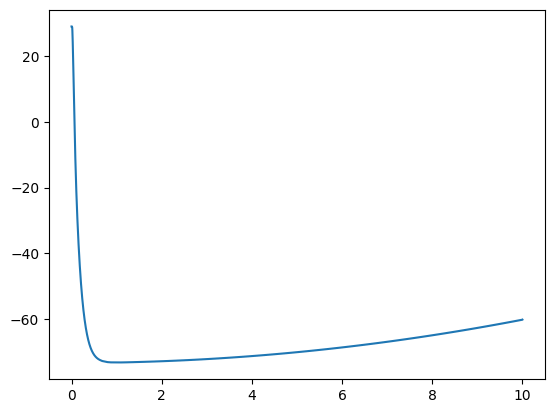

In [47]:
plt.plot(t_array, (np.array(p_pump_array) - np.array(p_fu_array))/1e5)
# plt.ylim([0,3])

Let's try and refactor this code for a new tool which considers the inertias of the cavities

In [212]:
t_stop = 10
t_init = 0


# Pump inlet condition and valve exit condition
inlet = IncompressibleFluid(rho=1000, P=30e5)
down = IncompressibleFluid(rho=1000, P=10e5)

# We initialise our working variables
alpha = 0.05
N = 0
I = 0.001
m_dot = 0
T_turbine = 0
T_pump = 0

# Array
N_pump_array = [N]
p_pump_array = [inlet.get_pressure()]
eta_pump_array = [pump.get_eta(Q=0, N=N)]
T_pump_array = [pump.get_torque(inlet=inlet, N=N, m_dot=0)]
T_turbine_array = [0]

t_array = [t_init]

Pcc_array = [P_cc_init]
dp_dt_array = [0]

T_array = [0]

MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]


# Upstream Fluid Conditions
ox_ups = IncompressibleFluid(P=50e5, rho=rho_ox)
fu_ups = IncompressibleFluid(P=50e5, rho=rho_fu)

# We setup our logging array
t_array = [t_init]
Pcc_array = [P_cc_init]
dp_dt_array = [0]
T_array = [0]
MR_array = [0]
m_ox_array = [0]
m_fu_array = [0]

ox_valve_array = [0]
fu_valve_array = [0]

p_ox_array = [ox_cavity.get_fluid().get_pressure()]
p_fu_array = [fu_cavity.get_fluid().get_pressure()]

################### SIMULATION CONDITIONS ###################
dp = 0.05e5
dt_fix = 0.01
dt_init = 1e-6
dt = dt_init

P_exit = 1e5

ox_valve.actuate(position=1)
fu_valve.actuate(position=1)

while t_array[-1] < t_stop:
    ######################## Update our cavities ###########################
    # We evaluate for our mass-flows considering inertial terms
    dm_dt_ox = (
        ox_ups.get_pressure() - p_ox_array[-1] - mox_valve_dp
    ) / ox_cavity.get_inertia()
    dm_dt_fu = (
        p_pump_array[-1] - p_fu_array[-1] - mfu_valve_va_dp
    ) / fu_cavity.get_inertia()

    m_dot_ox += dm_dt_ox * dt
    m_dot_fu += dm_dt_fu * dt

    # We update our cavity using the last mass_flow_rates
    m_ox_cav = (m_dot_ox - dic["m_dot_o"]) * dt
    m_fu_cav = (m_dot_fu - dic["m_dot_f"]) * dt

    ox_cavity.update_pressure(m_dot=m_ox_cav)
    fu_cavity.update_pressure(m_dot=m_fu_cav)

    ######################## Update our Pump Parmaeters #######################
    # We then perform our acceleration based on the delivered torque, and suplied torque
    dn_dt = (turbine_t - pump_t) / I

    N += dn_dt * dt

    ######################## Update our Chamber Conditions ##############################
    # We update our chamber pressure
    GG.set_pcc_transient(Pcc_array[-1] + dp_dt * dt)

    #------------------------------- NEXT TIMESTEP ---------------------------------------

    ######################## Get Pump Exit Parameters #######################
    pump_exit = pump.get_exit_condition(inlet=inlet, N=N, m_dot=m_dot)
    pump_t = pump.get_torque(inlet=inlet, N=N, m_dot=m_dot)

    ######################### turbine condition updatig ##############################
    # Firstly we need to update the valve positions
    ox_valve.update_pos(dt=dt)
    fu_valve.update_pos(dt=dt)

    # Now we need to evaluate for the instantaneous mass flow rates
    mox_valve_dp = ox_valve.get_inertial_param(upstr=ox_ups, downstr=ox_cavity.get_fluid())
    mfu_valve_va_dp = fu_valve.get_inertial_param(
        upstr=pump_exit, downstr=fu_cavity.get_fluid()
    )

    # We can get our injector fluid objects
    inj_ox = ox_cavity.get_fluid()
    inj_fu = fu_cavity.get_fluid()

    # We can do the combustion analysis of the chamber to see how our pressure rise is
    dic = GG.transient_time_step(ox_in=inj_ox, fu_in=inj_fu, eta_c=0.85)

    # We get the exit condition of the pump along with the torque

    R_gas = dic["Cp"] * (dic["gamma"] - 1) / dic["gamma"]

    # We evaluate turbine conditions
    turbine_t = dic["m_dot_t"] * turbine.get_torque(
        T_o=dic["T_o"],
        P_o=dic["P_cc"],
        gamma=dic["gamma"],
        R=R_gas,
        P_exit=P_exit,
    )

    N_pump_array.append(N)
    p_pump_array.append(pump_exit.get_pressure())
    eta_pump_array.append(pump.get_eta(Q=m_dot / inlet.get_density(), N=N))
    T_pump_array.append(pump_t)
    dp_max_array.append(pump.shut_off_head(N=N))
    q_max_array.append(pump.get_q_max(N=N))
    T_turbine_array.append(turbine_t)

    # Log current state
    Pcc_array.append(dic["P_cc"])
    T_array.append(dic["T_o"])
    MR_array.append(dic["MR"])
    dp_dt_array.append(dic["dp_dt"])

    m_ox_array.append(dic["m_dot_o"])
    m_fu_array.append(dic["m_dot_f"])

    p_ox_array.append(inj_ox.get_pressure())
    p_fu_array.append(inj_fu.get_pressure())

    ox_valve_array.append(m_dot_ox)
    fu_valve_array.append(m_dot_fu)

    dp_dt = dic["dp_dt"]
    # We solve for our time step

    dp_dt_ox = (p_ox_array[-2] - p_ox_array[-1]) / dt

    dp_dt_fu = (p_fu_array[-2] - p_fu_array[-1]) / dt

    dp_dt_time = max(abs(dp_dt), abs(dp_dt_ox), abs(dp_dt_fu))

    if dp_dt_time == 0:
        dt = dt_fix
    else:
        dt = dp / dp_dt_time

    if abs(dt) > dt_fix:
        dt = dt_fix

    t_array.append(t_array[-1] + dt)

    print(f"Current Timestep = {t_array[-1]}")


KeyboardInterrupt



## 3 - Appendix A: Comparison of c_star approach vs T_o directly

A comparison is made between the two approaches for getting the gas temperature, namely the direct approach and c_star approach.

In [ ]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5,2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star *eta_c

    gamma = cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1))**((gamma + 1)/(-2 * (gamma - 1)))

    R = 8314 / cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[0]
    # print(R)

    t_a.append((gamma/ (R))*(c_star_a / param)**2) 

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

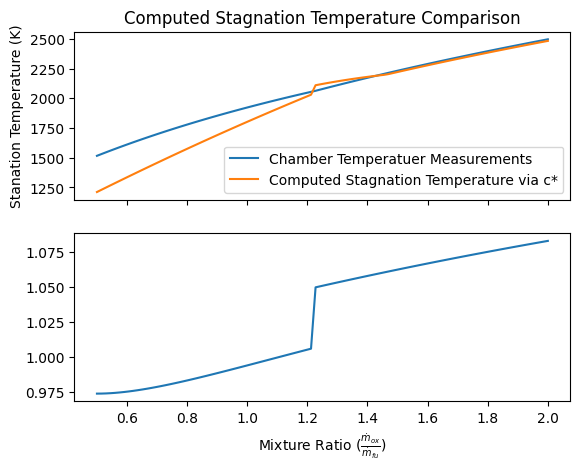

In [ ]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr , t_o, label="Chamber Temperatuer Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

As can be seen, at a mixture ratio of about 1.2, the specific heat ratio drops suddenly - resulting in a divergence in the two sets of results.

Let us now consider the case where instead of using chamber combustion conditions, we use the combustion conditions at the throat to figure out what our stagnation temperature is.

In [ ]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of)[0]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

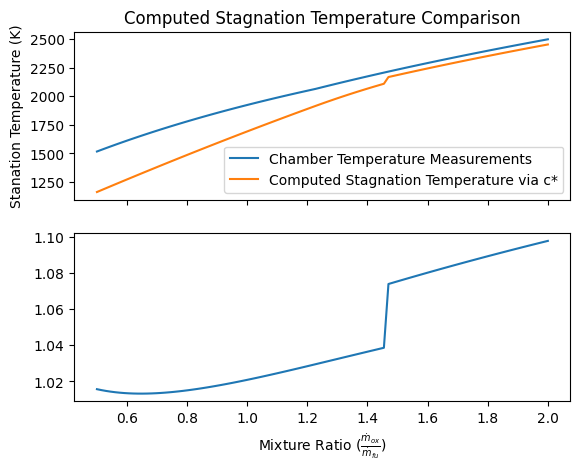

In [ ]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr, t_o, label="Chamber Temperature Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

A similar divergence can be seen, howeever this pccurs at a higher O/F.

If we plotted this against the temperature that is local to the throat, we may improve the siutation.

In [ ]:
eta_c = 1
t_a = []
t_o = []
gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Throat_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of)[1]))

Text(0.5, 0, 'Mixture Ratio ($\\frac{\\dot{m}_{ox}}{\\dot{m}_{fu}}$)')

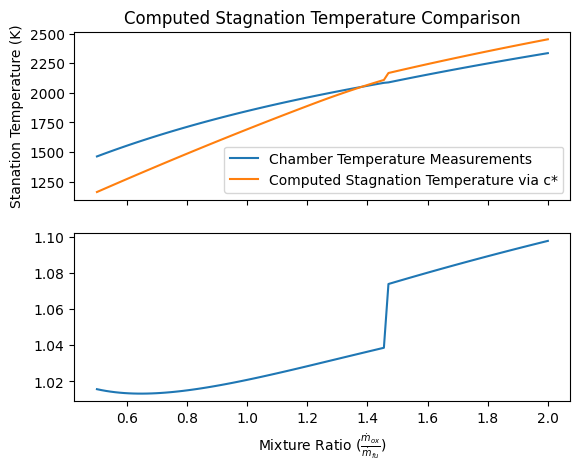

In [ ]:
fix, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(mr, t_o, label="Chamber Temperature Measurements")
ax[0].plot(mr, t_a, label="Computed Stagnation Temperature via c*")
ax[0].set_ylabel("Stanation Temperature (K)")
ax[0].set_title("Computed Stagnation Temperature Comparison")
ax[0].legend()

ax[1].plot(mr, gamma_a, label="Chamber Temperatuer Measurements")
ax[1].set_xlabel(r"Mixture Ratio ($\frac{\dot{m}_{ox}}{\dot{m}_{fu}}$)")

Now let's consider the case where we need to figure out what our stagnation temperature is at the outlet of our engine - lets compare the two approaches we have designed:

In [ ]:
eta_c = 0.85
t_a = []
t_o = []

t_ac = []
t_oc = []

gamma_a = []
mr = np.linspace(0.5, 2, 100)
pc = 30e5

for of in mr:

    c_star = cea.get_Cstar(Pc=pc, MR=of) * 0.3048
    c_star_a = c_star * eta_c

    gamma = cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[1]

    gamma_a.append(gamma)

    param = (2 / (gamma + 1)) ** ((gamma + 1) / (-2 * (gamma - 1)))

    R = 8314 / cea.get_Chamber_MolWt_gamma(Pc=pc, MR=of)[0]

    t_a.append((gamma / (R)) * (c_star / param) ** 2)
    t_ac.append((gamma / (R)) * (c_star_a / param) ** 2)

    t_o.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0]))
    t_oc.append((cea.get_Temperatures(Pc=pc, MR=of, frozen=1)[0] * eta_c**2))

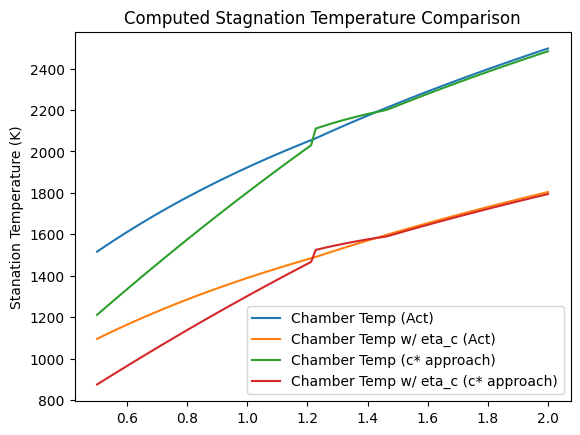

In [ ]:
fix, ax = plt.subplots(1, 1, sharex=True)

ax.plot(mr, t_o, label="Chamber Temp (Act)")
ax.plot(mr, t_oc, label="Chamber Temp w/ eta_c (Act)")

ax.plot(mr, t_a, label="Chamber Temp (c* approach)")
ax.plot(mr, t_ac, label="Chamber Temp w/ eta_c (c* approach)")

ax.set_ylabel("Stanation Temperature (K)")
ax.set_title("Computed Stagnation Temperature Comparison")
ax.legend()

In conclusion, the c_star approach will be used for the sizing of the throat and such parameters, however the actual approach will be used for the combustion modelling of the temperatuer.